In [ ]:
# baseline_snn_speech_commands.py
# Baseline SNN for Google Speech Commands v0.02
# Updated: April 26, 2025

import torch
import torch.nn as nn
import torchaudio
import snntorch as snn
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import matplotlib.pyplot as plt
import os

# Hyperparameters
batch_size = 64
num_steps = 100  # 1 second at 10 ms frames
num_inputs = 13 * 100  # 13 MFCCs, 100 frames
num_hidden = 100
num_outputs = 10  # 10 command words
learning_rate = 1e-3
num_epochs = 15
patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check dataset
dataset_dir = "speech_commands_v0.02"
if not os.path.exists(dataset_dir):
    print("Please download speech_commands_v0.02.tar.gz from http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz and extract to 'speech_commands_v0.02'")
    exit()

# Custom Dataset for Google Speech Commands
class SpeechCommandsDataset(Dataset):
    def __init__(self, root="speech_commands_v0.02", train=True, target_words=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]):
        self.root = root
        self.train = train
        self.target_words = target_words
        self.transform = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=13, n_fft=400, hop_length=160, f_min=20, f_max=4000)
        self.data = []
        self.labels = []
        split = "train" if train else "test"
        for word in os.listdir(root):
            if word in target_words:
                word_dir = os.path.join(root, word)
                for file in os.listdir(word_dir):
                    if file.endswith(".wav"):
                        file_path = os.path.join(word_dir, file)
                        label = target_words.index(word)
                        self.data.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(sample_rate, 16000)
            waveform = resampler(waveform)
        mfcc = self.transform(waveform)  # Shape: [13, num_frames]
        num_frames = mfcc.shape[1]
        if num_frames < 100:
            mfcc = torch.nn.functional.pad(mfcc, (0, 100 - num_frames))
        else:
            mfcc = mfcc[:, :100]
        return mfcc.flatten(), label  # Shape: [13 * 100]

# Load datasets
train_dataset = SpeechCommandsDataset(train=True)
test_dataset = SpeechCommandsDataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Surrogate gradient
spike_grad = surrogate.fast_sigmoid(slope=25)

# Baseline SNN
class BaselineSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        for layer in [self.fc1, self.fc2]:
            nn.init.xavier_uniform_(layer.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(1)
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        spk1_rec, spk2_rec = [], []
        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
        return torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0)

# Instantiate model and optimizer
net = BaselineSNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)
criterion = nn.CrossEntropyLoss()

# Training loop
best_val_accuracy = 0.0
epochs_no_improve = 0
accuracies, val_accuracies, losses, total_spikes_list = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    total_spikes = 0
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        batch_size_actual = data.size(0)
        if data.max() > 0:
            data = data / data.max()  # Normalize MFCCs
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
        spk1_rec, outputs = net(spike_data)
        spk_count = outputs.sum(dim=0)
        loss = criterion(spk_count, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0)
        optimizer.step()
        optimizer.zero_grad()
        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
        total_spikes += (spk1_rec.sum() + outputs.sum()).item()
    scheduler.step()
    losses.append(loss.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    val_total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)
            if data.max() > 0:
                data = data / data.max()
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
            spk1_rec, outputs = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            val_total_spikes += (spk1_rec.sum() + outputs.sum()).item()
        val_accuracy = total_correct / total_samples
        val_accuracies.append(val_accuracy)
        total_spikes_list.append(val_total_spikes)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {val_total_spikes:.0f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(total_spikes_list, label="Total Spikes")
plt.title("Total Spikes")
plt.legend()
plt.tight_layout()
plt.savefig("baseline_snn_results.png")
plt.show()

# Final summary
final_val_accuracy = max(val_accuracies)
final_total_spikes = total_spikes_list[val_accuracies.index(final_val_accuracy)]
energy = final_total_spikes * 20 / 1e6  # µJ
print("\nBaseline SNN Final Results:")
print(f"Peak Validation Accuracy: {final_val_accuracy:.2%}")
print(f"Total Spikes at Peak Accuracy: {final_total_spikes:.0f}")
print(f"Energy Consumption: {energy:.2f} µJ")

Please download speech_commands_v0.02.tar.gz from http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz and extract to 'speech_commands_v0.02'


TypeError: MFCC.__init__() got an unexpected keyword argument 'n_fft'

: 

1.26.4


In [1]:
# baseline_snn_speech_commands.py
import torch
import torch.nn as nn
import torchaudio
import snntorch as snn
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import matplotlib.pyplot as plt
import os

# Optional: Set soundfile backend if FFmpeg fails
try:
    torchaudio.set_audio_backend("soundfile")
    print(f"Using audio backend: {torchaudio.get_audio_backend()}")
except Exception as e:
    print(f"Failed to set soundfile backend: {e}, falling back to default")
    torchaudio.set_audio_backend("ffmpeg")  # Default if soundfile fails

# Hyperparameters
batch_size = 64
num_steps = 100
num_inputs = 13 * 100
num_hidden = 100
num_outputs = 10
learning_rate = 1e-3
num_epochs = 15
patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check dataset
dataset_dir = "speech_commands_v0.02"
if not os.path.exists(dataset_dir):
    print("Please download speech_commands_v0.02.tar.gz from http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz and extract to 'speech_commands_v0.02'")
    exit()

# Custom Dataset for Google Speech Commands
class SpeechCommandsDataset(Dataset):
    def __init__(self, root="speech_commands_v0.02", train=True, target_words=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]):
        self.root = root
        self.train = train
        self.target_words = target_words
        self.transform = torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=13, n_fft=400, hop_length=160, f_min=20, f_max=4000)
        self.data = []
        self.labels = []
        for word in os.listdir(root):
            if word in target_words:
                word_dir = os.path.join(root, word)
                for file in os.listdir(word_dir):
                    if file.endswith(".wav"):
                        file_path = os.path.join(word_dir, file)
                        label = target_words.index(word)
                        self.data.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(sample_rate, 16000)
            waveform = resampler(waveform)
        mfcc = self.transform(waveform)
        num_frames = mfcc.shape[1]
        if num_frames < 100:
            mfcc = torch.nn.functional.pad(mfcc, (0, 100 - num_frames))
        else:
            mfcc = mfcc[:, :100]
        return mfcc.flatten(), label

# Load datasets
train_dataset = SpeechCommandsDataset(train=True)
test_dataset = SpeechCommandsDataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Surrogate gradient
spike_grad = surrogate.fast_sigmoid(slope=25)

# Baseline SNN
class BaselineSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        for layer in [self.fc1, self.fc2]:
            nn.init.xavier_uniform_(layer.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(1)
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        spk1_rec, spk2_rec = [], []
        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
        return torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0)

# Instantiate model and optimizer
net = BaselineSNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)
criterion = nn.CrossEntropyLoss()

# Training loop
best_val_accuracy = 0.0
epochs_no_improve = 0
accuracies, val_accuracies, losses, total_spikes_list = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    total_spikes = 0
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        batch_size_actual = data.size(0)
        if data.max() > 0:
            data = data / data.max()
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
        spk1_rec, outputs = net(spike_data)
        spk_count = outputs.sum(dim=0)
        loss = criterion(spk_count, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0)
        optimizer.step()
        optimizer.zero_grad()
        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
        total_spikes += (spk1_rec.sum() + outputs.sum()).item()
    scheduler.step()
    losses.append(loss.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    val_total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)
            if data.max() > 0:
                data = data / data.max()
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
            spk1_rec, outputs = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            val_total_spikes += (spk1_rec.sum() + outputs.sum()).item()
        val_accuracy = total_correct / total_samples
        val_accuracies.append(val_accuracy)
        total_spikes_list.append(val_total_spikes)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {val_total_spikes:.0f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(total_spikes_list, label="Total Spikes")
plt.title("Total Spikes")
plt.legend()
plt.tight_layout()
plt.savefig("baseline_snn_results.png")
plt.show()

# Final summary
final_val_accuracy = max(val_accuracies)
final_total_spikes = total_spikes_list[val_accuracies.index(final_val_accuracy)]
energy = final_total_spikes * 20 / 1e6  # µJ
print("\nBaseline SNN Final Results:")
print(f"Peak Validation Accuracy: {final_val_accuracy:.2%}")
print(f"Total Spikes at Peak Accuracy: {final_total_spikes:.0f}")
print(f"Energy Consumption: {energy:.2f} µJ")

Using audio backend: None


C:\Users\Aswin Kumar\AppData\Local\Temp\ipykernel_13240\1004153853.py:13: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
C:\Users\Aswin Kumar\AppData\Local\Temp\ipykernel_13240\1004153853.py:14: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  print(f"Using audio backend: {torchaudio.get_audio_backend()}")


TypeError: MFCC.__init__() got an unexpected keyword argument 'n_fft'

In [2]:
import torch
import torch.nn as nn
import torchaudio
import snntorch as snn
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import matplotlib.pyplot as plt
import os

# Hyperparameters
batch_size = 64
num_steps = 100  # 1 second at 10 ms frames
num_inputs = 13 * 100  # 13 MFCCs, 100 frames
num_hidden = 100
num_outputs = 10  # 10 command words
learning_rate = 1e-3
num_epochs = 15
patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check dataset
dataset_dir = "speech_commands_v0.02"
if not os.path.exists(dataset_dir):
    print("Please download speech_commands_v0.02.tar.gz from http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz and extract to 'speech_commands_v0.02'")
    exit()

# Custom Dataset for Google Speech Commands
class SpeechCommandsDataset(Dataset):
    def __init__(self, root="speech_commands_v0.02", train=True, target_words=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]):
        self.root = root
        self.train = train
        self.target_words = target_words
        self.transform = torchaudio.transforms.MFCC(
            sample_rate=16000,
            n_mfcc=13,
            melkwargs={
                'n_fft': 400,
                'hop_length': 160,
                'f_min': 20,
                'f_max': 4000,
                'n_mels': 40
            }
        )
        self.data = []
        self.labels = []
        for word in os.listdir(root):
            if word in target_words:
                word_dir = os.path.join(root, word)
                for file in os.listdir(word_dir):
                    if file.endswith(".wav"):
                        file_path = os.path.join(word_dir, file)
                        label = target_words.index(word)
                        self.data.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(sample_rate, 16000)
            waveform = resampler(waveform)
        mfcc = self.transform(waveform)
        num_frames = mfcc.shape[1]
        if num_frames < 100:
            mfcc = torch.nn.functional.pad(mfcc, (0, 100 - num_frames))
        else:
            mfcc = mfcc[:, :100]
        return mfcc.flatten(), label

# Load datasets
train_dataset = SpeechCommandsDataset(train=True)
test_dataset = SpeechCommandsDataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Surrogate gradient
spike_grad = surrogate.fast_sigmoid(slope=25)

# Baseline SNN
class BaselineSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        for layer in [self.fc1, self.fc2]:
            nn.init.xavier_uniform_(layer.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(1)
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        spk1_rec, spk2_rec = [], []
        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
        return torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0)

# Instantiate model and optimizer
net = BaselineSNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)
criterion = nn.CrossEntropyLoss()

# Training loop
best_val_accuracy = 0.0
epochs_no_improve = 0
accuracies, val_accuracies, losses, total_spikes_list = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    total_spikes = 0
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        batch_size_actual = data.size(0)
        if data.max() > 0:
            data = data / data.max()
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
        spk1_rec, outputs = net(spike_data)
        spk_count = outputs.sum(dim=0)
        loss = criterion(spk_count, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0)
        optimizer.step()
        optimizer.zero_grad()
        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
        total_spikes += (spk1_rec.sum() + outputs.sum()).item()
    scheduler.step()
    losses.append(loss.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    val_total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)
            if data.max() > 0:
                data = data / data.max()
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
            spk1_rec, outputs = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            val_total_spikes += (spk1_rec.sum() + outputs.sum()).item()
        val_accuracy = total_correct / total_samples
        val_accuracies.append(val_accuracy)
        total_spikes_list.append(val_total_spikes)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {val_total_spikes:.0f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(total_spikes_list, label="Total Spikes")
plt.title("Total Spikes")
plt.legend()
plt.tight_layout()
plt.savefig("baseline_snn_results.png")
plt.show()

# Final summary
final_val_accuracy = max(val_accuracies)
final_total_spikes = total_spikes_list[val_accuracies.index(final_val_accuracy)]
energy = final_total_spikes * 20 / 1e6  # µJ
print("\nBaseline SNN Final Results:")
print(f"Peak Validation Accuracy: {final_val_accuracy:.2%}")
print(f"Total Spikes at Peak Accuracy: {final_total_spikes:.0f}")
print(f"Energy Consumption: {energy:.2f} µJ")

RuntimeError: stack expects each tensor to be equal size, but got [2444] at entry 0 and [2119] at entry 8

In [3]:
import torch
import torch.nn as nn
import torchaudio
import snntorch as snn
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import matplotlib.pyplot as plt
import os

# Hyperparameters
batch_size = 64
num_steps = 100  # 1 second at 10 ms frames
num_inputs = 13 * 100  # 13 MFCCs, 100 frames
num_hidden = 100
num_outputs = 10  # 10 command words
learning_rate = 1e-3
num_epochs = 15
patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check dataset
dataset_dir = "speech_commands_v0.02"
if not os.path.exists(dataset_dir):
    print("Please download speech_commands_v0.02.tar.gz from http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz and extract to 'speech_commands_v0.02'")
    exit()

# Custom Dataset for Google Speech Commands
class SpeechCommandsDataset(Dataset):
    def __init__(self, root="speech_commands_v0.02", train=True, target_words=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]):
        self.root = root
        self.train = train
        self.target_words = target_words
        self.transform = torchaudio.transforms.MFCC(
            sample_rate=16000,
            n_mfcc=13,
            melkwargs={
                'n_fft': 400,
                'hop_length': 160,
                'f_min': 20,
                'f_max': 4000,
                'n_mels': 40
            }
        )
        self.data = []
        self.labels = []
        for word in os.listdir(root):
            if word in target_words:
                word_dir = os.path.join(root, word)
                for file in os.listdir(word_dir):
                    if file.endswith(".wav"):
                        file_path = os.path.join(word_dir, file)
                        label = target_words.index(word)
                        self.data.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(sample_rate, 16000)
            waveform = resampler(waveform)
        mfcc = self.transform(waveform)
        num_frames = mfcc.shape[1]
        if num_frames < 100:
            mfcc = torch.nn.functional.pad(mfcc, (0, 100 - num_frames))
        else:
            mfcc = mfcc[:, :100]
        return mfcc.flatten(), label

# Load datasets
train_dataset = SpeechCommandsDataset(train=True)
test_dataset = SpeechCommandsDataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Surrogate gradient
spike_grad = surrogate.fast_sigmoid(slope=25)

# Baseline SNN
class BaselineSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        for layer in [self.fc1, self.fc2]:
            nn.init.xavier_uniform_(layer.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(1)
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        spk1_rec, spk2_rec = [], []
        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
        return torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0)

# Instantiate model and optimizer
net = BaselineSNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)
criterion = nn.CrossEntropyLoss()

# Training loop
best_val_accuracy = 0.0
epochs_no_improve = 0
accuracies, val_accuracies, losses, total_spikes_list = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    total_spikes = 0
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        batch_size_actual = data.size(0)
        if data.max() > 0:
            data = data / data.max()
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
        spk1_rec, outputs = net(spike_data)
        spk_count = outputs.sum(dim=0)
        loss = criterion(spk_count, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0)
        optimizer.step()
        optimizer.zero_grad()
        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
        total_spikes += (spk1_rec.sum() + outputs.sum()).item()
    scheduler.step()
    losses.append(loss.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    val_total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)
            if data.max() > 0:
                data = data / data.max()
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
            spk1_rec, outputs = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            val_total_spikes += (spk1_rec.sum() + outputs.sum()).item()
        val_accuracy = total_correct / total_samples
        val_accuracies.append(val_accuracy)
        total_spikes_list.append(val_total_spikes)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {val_total_spikes:.0f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(total_spikes_list, label="Total Spikes")
plt.title("Total Spikes")
plt.legend()
plt.tight_layout()
plt.savefig("baseline_snn_results.png")
plt.show()

# Final summary
final_val_accuracy = max(val_accuracies)
final_total_spikes = total_spikes_list[val_accuracies.index(final_val_accuracy)]
energy = final_total_spikes * 20 / 1e6  # µJ
print("\nBaseline SNN Final Results:")
print(f"Peak Validation Accuracy: {final_val_accuracy:.2%}")
print(f"Total Spikes at Peak Accuracy: {final_total_spikes:.0f}")
print(f"Energy Consumption: {energy:.2f} µJ")

RuntimeError: stack expects each tensor to be equal size, but got [2171] at entry 0 and [2444] at entry 1

In [4]:
import torch
import torch.nn as nn
import torchaudio
import snntorch as snn
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import matplotlib.pyplot as plt
import os

# Hyperparameters
batch_size = 64
num_steps = 100  # 1 second at 10 ms frames
num_inputs = 1300  # 13 MFCCs × 100 frames
num_hidden = 100
num_outputs = 10  # 10 command words
learning_rate = 1e-3
num_epochs = 15
patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check dataset
dataset_dir = "speech_commands_v0.02"
if not os.path.exists(dataset_dir):
    print("Please download speech_commands_v0.02.tar.gz from http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz and extract to 'speech_commands_v0.02'")
    exit()

# Custom Dataset for Google Speech Commands
class SpeechCommandsDataset(Dataset):
    def __init__(self, root="speech_commands_v0.02", train=True, target_words=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]):
        self.root = root
        self.train = train
        self.target_words = target_words
        self.transform = torchaudio.transforms.MFCC(
            sample_rate=16000,
            n_mfcc=13,
            melkwargs={
                'n_fft': 400,
                'hop_length': 160,
                'f_min': 20,
                'f_max': 4000,
                'n_mels': 40
            }
        )
        self.data = []
        self.labels = []
        for word in os.listdir(root):
            if word in target_words:
                word_dir = os.path.join(root, word)
                for file in os.listdir(word_dir):
                    if file.endswith(".wav"):
                        file_path = os.path.join(word_dir, file)
                        label = target_words.index(word)
                        self.data.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
            if waveform.numel() == 0:
                raise ValueError("Empty waveform")
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                waveform = resampler(waveform)
            mfcc = self.transform(waveform)
            if mfcc.dim() == 3 and mfcc.shape[0] == 1:
                mfcc = mfcc.squeeze(0)  # Shape: [13, num_frames]
            num_frames = mfcc.shape[1]
            if num_frames < 100:
                pad_width = 100 - num_frames
                mfcc = torch.nn.functional.pad(mfcc, (0, pad_width))
            elif num_frames > 100:
                mfcc = mfcc[:, :100]
            flattened = mfcc.flatten()  # Shape: [1300]
            return flattened, label
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            return torch.zeros(1300), -1  # Dummy tensor and label

# Custom collate function
def collate_fn(batch):
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    valid_indices = [i for i, target in enumerate(targets) if target != -1]
    if not valid_indices:
        return torch.zeros(1, 1300), torch.zeros(1, dtype=torch.long)
    data = [data[i] for i in valid_indices]
    targets = [targets[i] for i in valid_indices]
    data = torch.stack(data)
    targets = torch.tensor(targets)
    return data, targets

# Load datasets
train_dataset = SpeechCommandsDataset(train=True)
test_dataset = SpeechCommandsDataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Surrogate gradient
spike_grad = surrogate.fast_sigmoid(slope=25)

# Baseline SNN
class BaselineSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        for layer in [self.fc1, self.fc2]:
            nn.init.xavier_uniform_(layer.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(1)
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        spk1_rec, spk2_rec = [], []
        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
        return torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0)

# Instantiate model and optimizer
net = BaselineSNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)
criterion = nn.CrossEntropyLoss()

# Training loop
best_val_accuracy = 0.0
epochs_no_improve = 0
accuracies, val_accuracies, losses, total_spikes_list = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    total_spikes = 0
    for data, targets in train_loader:
        valid_indices = targets != -1
        if not valid_indices.any():
            continue
        data = data[valid_indices]
        targets = targets[valid_indices]
        data, targets = data.to(device), targets.to(device)
        batch_size_actual = data.size(0)
        if data.max() > 0:
            data = data / data.max()
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
        spk1_rec, outputs = net(spike_data)
        spk_count = outputs.sum(dim=0)
        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0)
        optimizer.step()
        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
        total_spikes += (spk1_rec.sum() + outputs.sum()).item()
    scheduler.step()
    losses.append(loss.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    val_total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            valid_indices = targets != -1
            if not valid_indices.any():
                continue
            data = data[valid_indices]
            targets = targets[valid_indices]
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)
            if data.max() > 0:
                data = data / data.max()
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data * 0.2).float()
            spk1_rec, outputs = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            val_total_spikes += (spk1_rec.sum() + outputs.sum()).item()
        val_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
        val_accuracies.append(val_accuracy)
        total_spikes_list.append(val_total_spikes)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {val_total_spikes:.0f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(total_spikes_list, label="Total Spikes")
plt.title("Total Spikes")
plt.legend()
plt.tight_layout()
plt.savefig("baseline_snn_results.png")
plt.show()

# Final summary
final_val_accuracy = max(val_accuracies) if val_accuracies else 0.0
final_total_spikes = total_spikes_list[val_accuracies.index(final_val_accuracy)] if val_accuracies else 0
energy = final_total_spikes * 20 / 1e6  # µJ
print("\nBaseline SNN Final Results:")
print(f"Peak Validation Accuracy: {final_val_accuracy:.2%}")
print(f"Total Spikes at Peak Accuracy: {final_total_spikes:.0f}")
print(f"Energy Consumption: {energy:.2f} µJ")

Epoch 1, Loss: 1.1823, Accuracy: 0.5556, Validation Accuracy: 0.4109, Total Spikes: 4550032
Epoch 2, Loss: 0.9965, Accuracy: 0.6667, Validation Accuracy: 0.4785, Total Spikes: 6609538
Epoch 3, Loss: 1.0580, Accuracy: 0.5556, Validation Accuracy: 0.5248, Total Spikes: 7864943
Epoch 4, Loss: 0.9512, Accuracy: 0.6111, Validation Accuracy: 0.5464, Total Spikes: 8573723
Epoch 5, Loss: 0.7383, Accuracy: 0.6667, Validation Accuracy: 0.5538, Total Spikes: 9200263
Epoch 6, Loss: 0.8862, Accuracy: 0.6667, Validation Accuracy: 0.5636, Total Spikes: 9662320
Epoch 7, Loss: 0.9828, Accuracy: 0.5556, Validation Accuracy: 0.5652, Total Spikes: 9776776
Epoch 8, Loss: 1.0497, Accuracy: 0.7222, Validation Accuracy: 0.5650, Total Spikes: 9874394
Epoch 9, Loss: 0.9734, Accuracy: 0.6111, Validation Accuracy: 0.5656, Total Spikes: 9923252
Epoch 10, Loss: 1.1593, Accuracy: 0.6111, Validation Accuracy: 0.5695, Total Spikes: 9964282
Epoch 11, Loss: 0.6891, Accuracy: 0.6667, Validation Accuracy: 0.5699, Total Sp

KeyboardInterrupt: 

In [6]:
import torch
import torch.nn as nn
import torchaudio
import snntorch as snn
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import matplotlib.pyplot as plt
import os

# Hyperparameters
batch_size = 64
num_steps = 100  # Number of time steps (frames)
num_inputs = 13  # 13 MFCC coefficients per frame
num_hidden = 256  # Increased for better capacity
num_outputs = 10  # 10 command words
learning_rate = 1e-3
num_epochs = 20
patience = 5
beta = 0.95  # Adjusted for longer memory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check dataset
dataset_dir = "speech_commands_v0.02"
if not os.path.exists(dataset_dir):
    print("Please download speech_commands_v0.02.tar.gz from http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz and extract to 'speech_commands_v0.02'")
    exit()

# Custom Dataset for Google Speech Commands
class SpeechCommandsDataset(Dataset):
    def __init__(self, root="speech_commands_v0.02", train=True, target_words=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]):
        self.root = root
        self.train = train
        self.target_words = target_words
        self.transform = torchaudio.transforms.MFCC(
            sample_rate=16000,
            n_mfcc=13,
            melkwargs={
                'n_fft': 400,
                'hop_length': 160,
                'f_min': 20,
                'f_max': 4000,
                'n_mels': 40
            }
        )
        self.data = []
        self.labels = []
        for word in os.listdir(root):
            if word in target_words:
                word_dir = os.path.join(root, word)
                for file in os.listdir(word_dir):
                    if file.endswith(".wav"):
                        file_path = os.path.join(word_dir, file)
                        label = target_words.index(word)
                        self.data.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
            if waveform.numel() == 0:
                raise ValueError("Empty waveform")
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                waveform = resampler(waveform)
            mfcc = self.transform(waveform)
            if mfcc.dim() == 3 and mfcc.shape[0] == 1:
                mfcc = mfcc.squeeze(0)  # Shape: [13, num_frames]
            num_frames = mfcc.shape[1]
            if num_frames < 100:
                pad_width = 100 - num_frames
                mfcc = torch.nn.functional.pad(mfcc, (0, pad_width))
            elif num_frames > 100:
                mfcc = mfcc[:, :100]
            mfcc = mfcc.transpose(0, 1)  # Shape: [100, 13]
            return mfcc, label
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            return torch.zeros(100, 13), -1  # Dummy tensor and label

# Custom collate function
def collate_fn(batch):
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    valid_indices = [i for i, target in enumerate(targets) if target != -1]
    if not valid_indices:
        return torch.zeros(1, 100, 13), torch.zeros(1, dtype=torch.long)
    data = [data[i] for i in valid_indices]
    targets = [targets[i] for i in valid_indices]
    data = torch.stack(data)
    targets = torch.tensor(targets)
    return data, targets

# Load datasets
train_dataset = SpeechCommandsDataset(train=True)
test_dataset = SpeechCommandsDataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# SNN Model
class SNN(nn.Module):
    def __init__(self, num_inputs=13, num_hidden=256, num_classes=10, beta=0.95):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))
        self.fc2 = nn.Linear(num_hidden, num_classes)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))
        for layer in [self.fc1, self.fc2]:
            nn.init.xavier_uniform_(layer.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(1)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        spk1_rec = []
        spk2_rec = []

        for step in range(x.size(0)):  # x: [num_steps, batch_size, 13]
            cur1 = self.fc1(x[step])  # x[step]: [batch_size, 13]
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)  # [num_steps, batch_size, num_classes]

# Instantiate model and optimizer
net = SNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
criterion = nn.CrossEntropyLoss()

# Training loop
best_val_accuracy = 0.0
epochs_no_improve = 0
accuracies, val_accuracies, losses, total_spikes_list = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    total_spikes = 0
    for data, targets in train_loader:
        valid_indices = targets != -1
        if not valid_indices.any():
            continue
        data = data[valid_indices]
        targets = targets[valid_indices]
        data, targets = data.to(device), targets.to(device)  # data: [batch_size, 100, 13]
        batch_size_actual = data.size(0)

        # Normalize MFCCs per sample to [0, 1]
        data_flat = data.view(batch_size_actual, -1)  # [batch_size, 1300]
        data_min = data_flat.min(dim=1, keepdim=True)[0].unsqueeze(2)  # [batch_size, 1, 1]
        data_max = data_flat.max(dim=1, keepdim=True)[0].unsqueeze(2)  # [batch_size, 1, 1]
        data = (data - data_min) / (data_max - data_min + 1e-8)
        data = torch.clamp(data, 0, 1)  # [batch_size, 100, 13]

        # Generate spikes: [num_steps, batch_size, 13]
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) <
                      data.permute(1, 0, 2) * 0.5).float()  # Increased scaling factor to 0.5

        # Forward pass
        outputs, _ = net(spike_data)
        spk_count = outputs.sum(dim=0)  # Sum over time steps: [batch_size, num_classes]
        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0)
        optimizer.step()

        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
        total_spikes += outputs.sum().item()

    scheduler.step()
    losses.append(loss.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    val_total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            valid_indices = targets != -1
            if not valid_indices.any():
                continue
            data = data[valid_indices]
            targets = targets[valid_indices]
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)

            # Normalize and generate spikes (same as training)
            data_flat = data.view(batch_size_actual, -1)
            data_min = data_flat.min(dim=1, keepdim=True)[0].unsqueeze(2)
            data_max = data_flat.max(dim=1, keepdim=True)[0].unsqueeze(2)
            data = (data - data_min) / (data_max - data_min + 1e-8)
            data = torch.clamp(data, 0, 1)
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) <
                          data.permute(1, 0, 2) * 0.5).float()
            outputs, _ = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            val_total_spikes += outputs.sum().item()

        val_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
        val_accuracies.append(val_accuracy)
        total_spikes_list.append(val_total_spikes)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {val_total_spikes:.0f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(total_spikes_list, label="Total Spikes")
plt.title("Total Spikes")
plt.legend()
plt.tight_layout()
plt.savefig("baseline_snn_results.png")
plt.show()

# Final summary
final_val_accuracy = max(val_accuracies) if val_accuracies else 0.0
final_total_spikes = total_spikes_list[val_accuracies.index(final_val_accuracy)] if val_accuracies else 0
energy = final_total_spikes * 20 / 1e6  # µJ
print("\nBaseline SNN Final Results:")
print(f"Peak Validation Accuracy: {final_val_accuracy:.2%}")
print(f"Total Spikes at Peak Accuracy: {final_total_spikes:.0f}")
print(f"Energy Consumption: {energy:.2f} µJ")

NameError: name 'mem2_rec' is not defined

In [7]:
import torch
import torch.nn as nn
import torchaudio
import snntorch as snn
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import matplotlib.pyplot as plt
import os

# Hyperparameters
batch_size = 64
num_steps = 100  # Number of time steps (frames)
num_inputs = 13  # 13 MFCC coefficients per frame
num_hidden = 256  # Increased for better capacity
num_outputs = 10  # 10 command words
learning_rate = 1e-3
num_epochs = 20
patience = 5
beta = 0.95  # Adjusted for longer memory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check dataset
dataset_dir = "speech_commands_v0.02"
if not os.path.exists(dataset_dir):
    print("Please download speech_commands_v0.02.tar.gz from http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz and extract to 'speech_commands_v0.02'")
    exit()

# Custom Dataset for Google Speech Commands
class SpeechCommandsDataset(Dataset):
    def __init__(self, root="speech_commands_v0.02", train=True, target_words=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]):
        self.root = root
        self.train = train
        self.target_words = target_words
        self.transform = torchaudio.transforms.MFCC(
            sample_rate=16000,
            n_mfcc=13,
            melkwargs={
                'n_fft': 400,
                'hop_length': 160,
                'f_min': 20,
                'f_max': 4000,
                'n_mels': 40
            }
        )
        self.data = []
        self.labels = []
        for word in os.listdir(root):
            if word in target_words:
                word_dir = os.path.join(root, word)
                for file in os.listdir(word_dir):
                    if file.endswith(".wav"):
                        file_path = os.path.join(word_dir, file)
                        label = target_words.index(word)
                        self.data.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
            if waveform.numel() == 0:
                raise ValueError("Empty waveform")
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                waveform = resampler(waveform)
            mfcc = self.transform(waveform)
            if mfcc.dim() == 3 and mfcc.shape[0] == 1:
                mfcc = mfcc.squeeze(0)  # Shape: [13, num_frames]
            num_frames = mfcc.shape[1]
            if num_frames < 100:
                pad_width = 100 - num_frames
                mfcc = torch.nn.functional.pad(mfcc, (0, pad_width))
            elif num_frames > 100:
                mfcc = mfcc[:, :100]
            mfcc = mfcc.transpose(0, 1)  # Shape: [100, 13]
            return mfcc, label
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            return torch.zeros(100, 13), -1  # Dummy tensor and label

# Custom collate function
def collate_fn(batch):
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    valid_indices = [i for i, target in enumerate(targets) if target != -1]
    if not valid_indices:
        return torch.zeros(1, 100, 13), torch.zeros(1, dtype=torch.long)
    data = [data[i] for i in valid_indices]
    targets = [targets[i] for i in valid_indices]
    data = torch.stack(data)
    targets = torch.tensor(targets)
    return data, targets

# Load datasets
train_dataset = SpeechCommandsDataset(train=True)
test_dataset = SpeechCommandsDataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# SNN Model
class SNN(nn.Module):
    def __init__(self, num_inputs=13, num_hidden=256, num_classes=10, beta=0.95):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))
        self.fc2 = nn.Linear(num_hidden, num_classes)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))
        for layer in [self.fc1, self.fc2]:
            nn.init.xavier_uniform_(layer.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(1)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        spk1_rec = []
        spk2_rec = []
        mem2_rec = []  # Added to store membrane potentials

        for step in range(x.size(0)):  # x: [num_steps, batch_size, 13]
            cur1 = self.fc1(x[step])  # x[step]: [batch_size, 13]
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)  # Store mem2 at each step

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)  # [num_steps, batch_size, num_classes]

# Instantiate model and optimizer
net = SNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
criterion = nn.CrossEntropyLoss()

# Training loop
best_val_accuracy = 0.0
epochs_no_improve = 0
accuracies, val_accuracies, losses, total_spikes_list = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    total_spikes = 0
    for data, targets in train_loader:
        valid_indices = targets != -1
        if not valid_indices.any():
            continue
        data = data[valid_indices]
        targets = targets[valid_indices]
        data, targets = data.to(device), targets.to(device)  # data: [batch_size, 100, 13]
        batch_size_actual = data.size(0)

        # Normalize MFCCs per sample to [0, 1]
        data_flat = data.view(batch_size_actual, -1)  # [batch_size, 1300]
        data_min = data_flat.min(dim=1, keepdim=True)[0].unsqueeze(2)  # [batch_size, 1, 1]
        data_max = data_flat.max(dim=1, keepdim=True)[0].unsqueeze(2)  # [batch_size, 1, 1]
        data = (data - data_min) / (data_max - data_min + 1e-8)
        data = torch.clamp(data, 0, 1)  # [batch_size, 100, 13]

        # Generate spikes: [num_steps, batch_size, 13]
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) <
                      data.permute(1, 0, 2) * 0.5).float()  # Increased scaling factor to 0.5

        # Forward pass
        outputs, _ = net(spike_data)
        spk_count = outputs.sum(dim=0)  # Sum over time steps: [batch_size, num_classes]
        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0)
        optimizer.step()

        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
        total_spikes += outputs.sum().item()

    scheduler.step()
    losses.append(loss.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    val_total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            valid_indices = targets != -1
            if not valid_indices.any():
                continue
            data = data[valid_indices]
            targets = targets[valid_indices]
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)

            # Normalize and generate spikes (same as training)
            data_flat = data.view(batch_size_actual, -1)
            data_min = data_flat.min(dim=1, keepdim=True)[0].unsqueeze(2)
            data_max = data_flat.max(dim=1, keepdim=True)[0].unsqueeze(2)
            data = (data - data_min) / (data_max - data_min + 1e-8)
            data = torch.clamp(data, 0, 1)
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) <
                          data.permute(1, 0, 2) * 0.5).float()
            outputs, _ = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            val_total_spikes += outputs.sum().item()

        val_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
        val_accuracies.append(val_accuracy)
        total_spikes_list.append(val_total_spikes)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {val_total_spikes:.0f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(total_spikes_list, label="Total Spikes")
plt.title("Total Spikes")
plt.legend()
plt.tight_layout()
plt.savefig("baseline_snn_results.png")
plt.show()

# Final summary
final_val_accuracy = max(val_accuracies) if val_accuracies else 0.0
final_total_spikes = total_spikes_list[val_accuracies.index(final_val_accuracy)] if val_accuracies else 0
energy = final_total_spikes * 20 / 1e6  # µJ
print("\nBaseline SNN Final Results:")
print(f"Peak Validation Accuracy: {final_val_accuracy:.2%}")
print(f"Total Spikes at Peak Accuracy: {final_total_spikes:.0f}")
print(f"Energy Consumption: {energy:.2f} µJ")

Epoch 1, Loss: 2.3202, Accuracy: 0.0556, Validation Accuracy: 0.1144, Total Spikes: 3496
Epoch 2, Loss: 2.3075, Accuracy: 0.1667, Validation Accuracy: 0.1409, Total Spikes: 48824
Epoch 3, Loss: 2.3297, Accuracy: 0.1667, Validation Accuracy: 0.1548, Total Spikes: 204940


KeyboardInterrupt: 

In [9]:
import torch
import torch.nn as nn
import torchaudio
import snntorch as snn
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import matplotlib.pyplot as plt
import os

# Hyperparameters
batch_size = 64
num_steps = 100  # Number of time steps (frames)
num_inputs = 13  # 13 MFCC coefficients per frame
num_hidden = 512  # Increased for better capacity
num_outputs = 10  # 10 command words
learning_rate = 5e-3  # Increased learning rate
num_epochs = 20
patience = 5
beta = 0.95  # Adjusted for longer memory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check dataset
dataset_dir = "speech_commands_v0.02"
if not os.path.exists(dataset_dir):
    print("Please download speech_commands_v0.02.tar.gz from http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz and extract to 'speech_commands_v0.02'")
    exit()

# Custom Dataset for Google Speech Commands
class SpeechCommandsDataset(Dataset):
    def __init__(self, root="speech_commands_v0.02", train=True, target_words=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]):
        self.root = root
        self.train = train
        self.target_words = target_words
        self.transform = torchaudio.transforms.MFCC(
            sample_rate=16000,
            n_mfcc=13,
            melkwargs={
                'n_fft': 400,
                'hop_length': 160,
                'f_min': 20,
                'f_max': 4000,
                'n_mels': 40
            }
        )
        self.data = []
        self.labels = []
        for word in os.listdir(root):
            if word in target_words:
                word_dir = os.path.join(root, word)
                for file in os.listdir(word_dir):
                    if file.endswith(".wav"):
                        file_path = os.path.join(word_dir, file)
                        label = target_words.index(word)
                        self.data.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
            if waveform.numel() == 0:
                raise ValueError("Empty waveform")
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                waveform = resampler(waveform)
            # Add noise augmentation for training
            if self.train:
                noise = torch.randn_like(waveform) * 0.005
                waveform = waveform + noise
            mfcc = self.transform(waveform)
            if mfcc.dim() == 3 and mfcc.shape[0] == 1:
                mfcc = mfcc.squeeze(0)  # Shape: [13, num_frames]
            num_frames = mfcc.shape[1]
            if num_frames < 100:
                pad_width = 100 - num_frames
                mfcc = torch.nn.functional.pad(mfcc, (0, pad_width))
            elif num_frames > 100:
                mfcc = mfcc[:, :100]
            mfcc = mfcc.transpose(0, 1)  # Shape: [100, 13]
            return mfcc, label
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            return torch.zeros(100, 13), -1  # Dummy tensor and label

# Custom collate function
def collate_fn(batch):
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    valid_indices = [i for i, target in enumerate(targets) if target != -1]
    if not valid_indices:
        return torch.zeros(1, 100, 13), torch.zeros(1, dtype=torch.long)
    data = [data[i] for i in valid_indices]
    targets = [targets[i] for i in valid_indices]
    data = torch.stack(data)
    targets = torch.tensor(targets)
    return data, targets

# Load datasets
train_dataset = SpeechCommandsDataset(train=True)
test_dataset = SpeechCommandsDataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# SNN Model with Convolution
class SNN(nn.Module):
    def __init__(self, num_inputs=13, num_hidden=512, num_classes=10, beta=0.95):
        super().__init__()
        # 1D Convolution to capture local patterns in MFCC frames
        self.conv1 = nn.Conv1d(in_channels=num_inputs, out_channels=32, kernel_size=5, padding=2)
        self.lif_conv = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))
        # Fully connected layers
        self.fc1 = nn.Linear(32, num_hidden)  # Input is 32 features per step
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))
        self.fc2 = nn.Linear(num_hidden, num_classes)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))
        for layer in [self.conv1, self.fc1, self.fc2]:
            if hasattr(layer, 'weight'):
                nn.init.xavier_uniform_(layer.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(1)
        mem_conv = self.lif_conv.init_leaky()
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Process the entire sequence with convolution
        conv_in = x.transpose(1, 2)  # [num_steps, batch_size, 13] -> [batch_size, 13, num_steps]
        conv_out = self.conv1(conv_in)  # [batch_size, 32, num_steps]
        conv_out = conv_out.transpose(1, 2)  # [batch_size, num_steps, 32]

        spk2_rec = []
        mem2_rec = []

        for step in range(conv_out.size(1)):  # Iterate over num_steps
            spk_conv, mem_conv = self.lif_conv(conv_out[:, step, :], mem_conv)  # [batch_size, 32]
            cur1 = self.fc1(spk_conv)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)  # [num_steps, batch_size, num_classes]

# Instantiate model and optimizer
net = SNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Training loop
best_val_accuracy = 0.0
epochs_no_improve = 0
accuracies, val_accuracies, losses, total_spikes_list = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    total_spikes = 0
    for data, targets in train_loader:
        valid_indices = targets != -1
        if not valid_indices.any():
            continue
        data = data[valid_indices]
        targets = targets[valid_indices]
        data, targets = data.to(device), targets.to(device)  # data: [batch_size, 100, 13]
        batch_size_actual = data.size(0)

        # Normalize MFCCs per sample to [0, 1]
        data_flat = data.view(batch_size_actual, -1)  # [batch_size, 1300]
        data_min = data_flat.min(dim=1, keepdim=True)[0].unsqueeze(2)  # [batch_size, 1, 1]
        data_max = data_flat.max(dim=1, keepdim=True)[0].unsqueeze(2)  # [batch_size, 1, 1]
        data = (data - data_min) / (data_max - data_min + 1e-8)
        data = torch.clamp(data, 0, 1)  # [batch_size, 100, 13]

        # Generate spikes: [num_steps, batch_size, 13]
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) <
                      data.permute(1, 0, 2) * 1.0).float()  # Increased scaling factor to 1.0

        # Forward pass
        outputs, _ = net(spike_data)
        # Weighted sum of spikes (emphasize later time steps)
        weights = torch.linspace(0.1, 1.0, steps=num_steps, device=device).view(-1, 1, 1)
        spk_count = (outputs * weights).sum(dim=0)  # [batch_size, num_classes]
        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0)
        optimizer.step()

        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
        total_spikes += outputs.sum().item()

    scheduler.step()
    losses.append(loss.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    val_total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            valid_indices = targets != -1
            if not valid_indices.any():
                continue
            data = data[valid_indices]
            targets = targets[valid_indices]
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)

            # Normalize and generate spikes (same as training)
            data_flat = data.view(batch_size_actual, -1)
            data_min = data_flat.min(dim=1, keepdim=True)[0].unsqueeze(2)
            data_max = data_flat.max(dim=1, keepdim=True)[0].unsqueeze(2)
            data = (data - data_min) / (data_max - data_min + 1e-8)
            data = torch.clamp(data, 0, 1)
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) <
                          data.permute(1, 0, 2) * 1.0).float()
            outputs, _ = net(spike_data)
            weights = torch.linspace(0.1, 1.0, steps=num_steps, device=device).view(-1, 1, 1)
            spk_count = (outputs * weights).sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            val_total_spikes += outputs.sum().item()

        val_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
        val_accuracies.append(val_accuracy)
        total_spikes_list.append(val_total_spikes)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {val_total_spikes:.0f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(total_spikes_list, label="Total Spikes")
plt.title("Total Spikes")
plt.legend()
plt.tight_layout()
plt.savefig("baseline_snn_results.png")
plt.show()

# Final summary
final_val_accuracy = max(val_accuracies) if val_accuracies else 0.0
final_total_spikes = total_spikes_list[val_accuracies.index(final_val_accuracy)] if val_accuracies else 0
energy = final_total_spikes * 20 / 1e6  # µJ
print("\nBaseline SNN Final Results:")
print(f"Peak Validation Accuracy: {final_val_accuracy:.2%}")
print(f"Total Spikes at Peak Accuracy: {final_total_spikes:.0f}")
print(f"Energy Consumption: {energy:.2f} µJ")

RuntimeError: The size of tensor a (64) must match the size of tensor b (100) at non-singleton dimension 0

In [10]:
import torch
import torch.nn as nn
import torchaudio
import snntorch as snn
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import matplotlib.pyplot as plt
import os

# Hyperparameters
batch_size = 64
num_steps = 100  # Number of time steps (frames)
num_inputs = 13  # 13 MFCC coefficients per frame
num_hidden = 512  # Increased for better capacity
num_outputs = 10  # 10 command words
learning_rate = 5e-3  # Increased learning rate
num_epochs = 20
patience = 5
beta = 0.95  # Adjusted for longer memory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check dataset
dataset_dir = "speech_commands_v0.02"
if not os.path.exists(dataset_dir):
    print("Please download speech_commands_v0.02.tar.gz from http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz and extract to 'speech_commands_v0.02'")
    exit()

# Custom Dataset for Google Speech Commands
class SpeechCommandsDataset(Dataset):
    def __init__(self, root="speech_commands_v0.02", train=True, target_words=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]):
        self.root = root
        self.train = train
        self.target_words = target_words
        self.transform = torchaudio.transforms.MFCC(
            sample_rate=16000,
            n_mfcc=13,
            melkwargs={
                'n_fft': 400,
                'hop_length': 160,
                'f_min': 20,
                'f_max': 4000,
                'n_mels': 40
            }
        )
        self.data = []
        self.labels = []
        for word in os.listdir(root):
            if word in target_words:
                word_dir = os.path.join(root, word)
                for file in os.listdir(word_dir):
                    if file.endswith(".wav"):
                        file_path = os.path.join(word_dir, file)
                        label = target_words.index(word)
                        self.data.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
            if waveform.numel() == 0:
                raise ValueError("Empty waveform")
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                waveform = resampler(waveform)
            # Add noise augmentation for training
            if self.train:
                noise = torch.randn_like(waveform) * 0.005
                waveform = waveform + noise
            mfcc = self.transform(waveform)
            if mfcc.dim() == 3 and mfcc.shape[0] == 1:
                mfcc = mfcc.squeeze(0)  # Shape: [13, num_frames]
            num_frames = mfcc.shape[1]
            if num_frames < 100:
                pad_width = 100 - num_frames
                mfcc = torch.nn.functional.pad(mfcc, (0, pad_width))
            elif num_frames > 100:
                mfcc = mfcc[:, :100]
            mfcc = mfcc.transpose(0, 1)  # Shape: [100, 13]
            return mfcc, label
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            return torch.zeros(100, 13), -1  # Dummy tensor and label

# Custom collate function
def collate_fn(batch):
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    valid_indices = [i for i, target in enumerate(targets) if target != -1]
    if not valid_indices:
        return torch.zeros(1, 100, 13), torch.zeros(1, dtype=torch.long)
    data = [data[i] for i in valid_indices]
    targets = [targets[i] for i in valid_indices]
    data = torch.stack(data)
    targets = torch.tensor(targets)
    return data, targets

# Load datasets
train_dataset = SpeechCommandsDataset(train=True)
test_dataset = SpeechCommandsDataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# SNN Model with Convolution
class SNN(nn.Module):
    def __init__(self, num_inputs=13, num_hidden=512, num_classes=10, beta=0.95):
        super().__init__()
        # 1D Convolution to capture local patterns in MFCC frames
        self.conv1 = nn.Conv1d(in_channels=num_inputs, out_channels=32, kernel_size=5, padding=2)
        self.lif_conv = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))
        # Fully connected layers
        self.fc1 = nn.Linear(32, num_hidden)  # Input is 32 features per step
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))
        self.fc2 = nn.Linear(num_hidden, num_classes)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))
        for layer in [self.conv1, self.fc1, self.fc2]:
            if hasattr(layer, 'weight'):
                nn.init.xavier_uniform_(layer.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(1)
        mem_conv = self.lif_conv.init_leaky()
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Process the entire sequence with convolution
        conv_in = x.transpose(1, 2)  # [num_steps, batch_size, 13] -> [batch_size, 13, num_steps]
        conv_out = self.conv1(conv_in)  # [batch_size, 32, num_steps]
        conv_out = conv_out.transpose(1, 2)  # [batch_size, num_steps, 32]

        spk2_rec = []
        mem2_rec = []

        for step in range(conv_out.size(1)):  # Iterate over num_steps
            spk_conv, mem_conv = self.lif_conv(conv_out[:, step, :], mem_conv)  # [batch_size, 32]
            cur1 = self.fc1(spk_conv)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)  # [num_steps, batch_size, num_classes]

# Instantiate model and optimizer
net = SNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Training loop
best_val_accuracy = 0.0
epochs_no_improve = 0
accuracies, val_accuracies, losses, total_spikes_list = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    total_spikes = 0
    for data, targets in train_loader:
        valid_indices = targets != -1
        if not valid_indices.any():
            continue
        data = data[valid_indices]
        targets = targets[valid_indices]
        data, targets = data.to(device), targets.to(device)  # data: [batch_size, 100, 13]
        batch_size_actual = data.size(0)

        # Normalize MFCCs per sample to [0, 1]
        data_flat = data.view(batch_size_actual, -1)  # [batch_size, 1300]
        data_min = data_flat.min(dim=1, keepdim=True)[0].unsqueeze(2)  # [batch_size, 1, 1]
        data_max = data_flat.max(dim=1, keepdim=True)[0].unsqueeze(2)  # [batch_size, 1, 1]
        data = (data - data_min) / (data_max - data_min + 1e-8)
        data = torch.clamp(data, 0, 1)  # [batch_size, 100, 13]

        # Generate spikes: [num_steps, batch_size, 13]
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) <
                      data.permute(1, 0, 2) * 1.0).float()  # Increased scaling factor to 1.0

        # Forward pass
        outputs, _ = net(spike_data)  # outputs: [num_steps, batch_size, num_classes]
        # Weighted sum of spikes (emphasize later time steps)
        weights = torch.linspace(0.1, 1.0, steps=num_steps, device=device).view(num_steps, 1, 1)
        weighted_outputs = outputs * weights  # [num_steps, batch_size, num_classes]
        spk_count = weighted_outputs.sum(dim=0)  # [batch_size, num_classes]
        # Debug shapes
        if spk_count.size(0) != targets.size(0):
            print(f"Shape mismatch: spk_count {spk_count.size()}, targets {targets.size()}")
            continue
        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0)
        optimizer.step()

        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
        total_spikes += outputs.sum().item()

    scheduler.step()
    losses.append(loss.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    val_total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            valid_indices = targets != -1
            if not valid_indices.any():
                continue
            data = data[valid_indices]
            targets = targets[valid_indices]
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)

            # Normalize and generate spikes (same as training)
            data_flat = data.view(batch_size_actual, -1)
            data_min = data_flat.min(dim=1, keepdim=True)[0].unsqueeze(2)
            data_max = data_flat.max(dim=1, keepdim=True)[0].unsqueeze(2)
            data = (data - data_min) / (data_max - data_min + 1e-8)
            data = torch.clamp(data, 0, 1)
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) <
                          data.permute(1, 0, 2) * 1.0).float()
            outputs, _ = net(spike_data)
            weights = torch.linspace(0.1, 1.0, steps=num_steps, device=device).view(num_steps, 1, 1)
            weighted_outputs = outputs * weights
            spk_count = weighted_outputs.sum(dim=0)
            if spk_count.size(0) != targets.size(0):
                print(f"Validation shape mismatch: spk_count {spk_count.size()}, targets {targets.size()}")
                continue
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            val_total_spikes += outputs.sum().item()

        val_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
        val_accuracies.append(val_accuracy)
        total_spikes_list.append(val_total_spikes)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {val_total_spikes:.0f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(total_spikes_list, label="Total Spikes")
plt.title("Total Spikes")
plt.legend()
plt.tight_layout()
plt.savefig("baseline_snn_results.png")
plt.show()

# Final summary
final_val_accuracy = max(val_accuracies) if val_accuracies else 0.0
final_total_spikes = total_spikes_list[val_accuracies.index(final_val_accuracy)] if val_accuracies else 0
energy = final_total_spikes * 20 / 1e6  # µJ
print("\nBaseline SNN Final Results:")
print(f"Peak Validation Accuracy: {final_val_accuracy:.2%}")
print(f"Total Spikes at Peak Accuracy: {final_total_spikes:.0f}")
print(f"Energy Consumption: {energy:.2f} µJ")

RuntimeError: The size of tensor a (64) must match the size of tensor b (100) at non-singleton dimension 0

outputs shape: torch.Size([100, 64, 10])
targets shape: torch.Size([64])
outputs shape: torch.Size([100, 64, 10])
targets shape: torch.Size([64])
outputs shape: torch.Size([100, 64, 10])
targets shape: torch.Size([64])
outputs shape: torch.Size([100, 64, 10])
targets shape: torch.Size([64])
outputs shape: torch.Size([100, 64, 10])
targets shape: torch.Size([64])
outputs shape: torch.Size([100, 64, 10])
targets shape: torch.Size([64])
outputs shape: torch.Size([100, 64, 10])
targets shape: torch.Size([64])
outputs shape: torch.Size([100, 64, 10])
targets shape: torch.Size([64])
outputs shape: torch.Size([100, 64, 10])
targets shape: torch.Size([64])
outputs shape: torch.Size([100, 64, 10])
targets shape: torch.Size([64])
outputs shape: torch.Size([100, 64, 10])
targets shape: torch.Size([64])
outputs shape: torch.Size([100, 64, 10])
targets shape: torch.Size([64])
outputs shape: torch.Size([100, 64, 10])
targets shape: torch.Size([64])
outputs shape: torch.Size([100, 64, 10])
targets sh

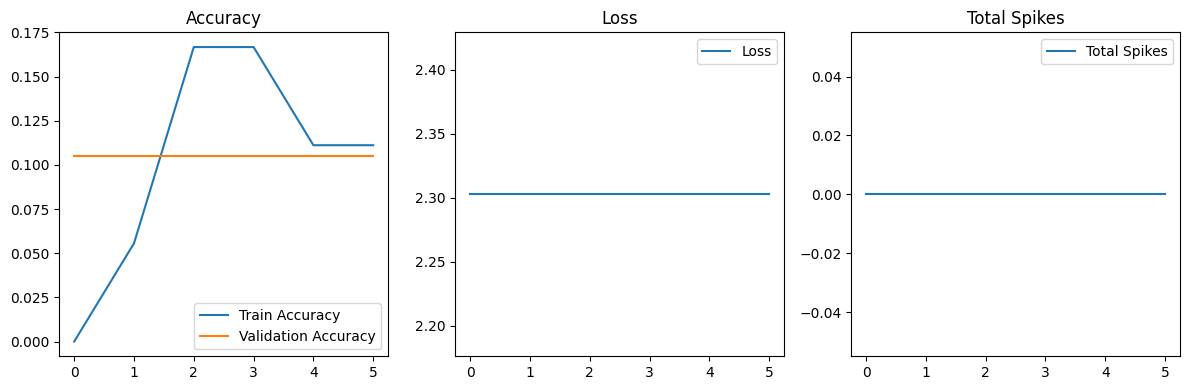


Baseline SNN Final Results:
Peak Validation Accuracy: 10.49%
Total Spikes at Peak Accuracy: 0
Energy Consumption: 0.00 µJ


In [11]:
import torch
import torch.nn as nn
import torchaudio
import snntorch as snn
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import matplotlib.pyplot as plt
import os

# Hyperparameters
batch_size = 64
num_steps = 100  # Number of time steps (frames)
num_inputs = 13  # 13 MFCC coefficients per frame
num_hidden = 512  # Increased for better capacity
num_outputs = 10  # 10 command words
learning_rate = 5e-3  # Increased learning rate
num_epochs = 20
patience = 5
beta = 0.95  # Adjusted for longer memory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check dataset
dataset_dir = "speech_commands_v0.02"
if not os.path.exists(dataset_dir):
    print("Please download speech_commands_v0.02.tar.gz from http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz and extract to 'speech_commands_v0.02'")
    exit()

# Custom Dataset for Google Speech Commands
class SpeechCommandsDataset(Dataset):
    def __init__(self, root="speech_commands_v0.02", train=True, target_words=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]):
        self.root = root
        self.train = train
        self.target_words = target_words
        self.transform = torchaudio.transforms.MFCC(
            sample_rate=16000,
            n_mfcc=13,
            melkwargs={
                'n_fft': 400,
                'hop_length': 160,
                'f_min': 20,
                'f_max': 4000,
                'n_mels': 40
            }
        )
        self.data = []
        self.labels = []
        for word in os.listdir(root):
            if word in target_words:
                word_dir = os.path.join(root, word)
                for file in os.listdir(word_dir):
                    if file.endswith(".wav"):
                        file_path = os.path.join(word_dir, file)
                        label = target_words.index(word)
                        self.data.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
            if waveform.numel() == 0:
                raise ValueError("Empty waveform")
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                waveform = resampler(waveform)
            # Add noise augmentation for training
            if self.train:
                noise = torch.randn_like(waveform) * 0.005
                waveform = waveform + noise
            mfcc = self.transform(waveform)
            if mfcc.dim() == 3 and mfcc.shape[0] == 1:
                mfcc = mfcc.squeeze(0)  # Shape: [13, num_frames]
            num_frames = mfcc.shape[1]
            if num_frames < 100:
                pad_width = 100 - num_frames
                mfcc = torch.nn.functional.pad(mfcc, (0, pad_width))
            elif num_frames > 100:
                mfcc = mfcc[:, :100]
            mfcc = mfcc.transpose(0, 1)  # Shape: [100, 13]
            return mfcc, label
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            return torch.zeros(100, 13), -1  # Dummy tensor and label

# Custom collate function
def collate_fn(batch):
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    valid_indices = [i for i, target in enumerate(targets) if target != -1]
    if not valid_indices:
        return torch.zeros(1, 100, 13), torch.zeros(1, dtype=torch.long)
    data = [data[i] for i in valid_indices]
    targets = [targets[i] for i in valid_indices]
    data = torch.stack(data)
    targets = torch.tensor(targets)
    return data, targets

# Load datasets
train_dataset = SpeechCommandsDataset(train=True)
test_dataset = SpeechCommandsDataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# SNN Model with Convolution
class SNN(nn.Module):
    def __init__(self, num_inputs=13, num_hidden=512, num_classes=10, beta=0.95):
        super().__init__()
        # 1D Convolution to capture local patterns in MFCC frames
        self.conv1 = nn.Conv1d(in_channels=num_inputs, out_channels=32, kernel_size=5, padding=2)
        self.lif_conv = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))
        # Fully connected layers
        self.fc1 = nn.Linear(32, num_hidden)  # Input is 32 features per step
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))
        self.fc2 = nn.Linear(num_hidden, num_classes)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=25))
        for layer in [self.conv1, self.fc1, self.fc2]:
            if hasattr(layer, 'weight'):
                nn.init.xavier_uniform_(layer.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(1)
        mem_conv = self.lif_conv.init_leaky()
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Process the entire sequence with convolution
        conv_in = x.transpose(1, 2)  # [num_steps, batch_size, 13] -> [batch_size, 13, num_steps]
        conv_out = self.conv1(conv_in)  # [batch_size, 32, num_steps]
        conv_out = conv_out.transpose(1, 2)  # [batch_size, num_steps, 32]

        spk2_rec = []
        mem2_rec = []

        for step in range(conv_out.size(1)):  # Iterate over num_steps
            spk_conv, mem_conv = self.lif_conv(conv_out[:, step, :], mem_conv)  # [batch_size, 32]
            cur1 = self.fc1(spk_conv)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)  # [num_steps, batch_size, num_classes]

# Instantiate model and optimizer
net = SNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Training loop
best_val_accuracy = 0.0
epochs_no_improve = 0
accuracies, val_accuracies, losses, total_spikes_list = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    total_spikes = 0
    for data, targets in train_loader:
        valid_indices = targets != -1
        if not valid_indices.any():
            continue
        data = data[valid_indices]
        targets = targets[valid_indices]
        data, targets = data.to(device), targets.to(device)  # data: [batch_size, 100, 13]
        batch_size_actual = data.size(0)

        # Normalize MFCCs per sample to [0, 1]
        data_flat = data.view(batch_size_actual, -1)  # [batch_size, 1300]
        data_min = data_flat.min(dim=1, keepdim=True)[0].unsqueeze(2)  # [batch_size, 1, 1]
        data_max = data_flat.max(dim=1, keepdim=True)[0].unsqueeze(2)  # [batch_size, 1, 1]
        data = (data - data_min) / (data_max - data_min + 1e-8)
        data = torch.clamp(data, 0, 1)  # [batch_size, 100, 13]

        # Generate spikes: [num_steps, batch_size, 13]
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) <
                      data.permute(1, 0, 2) * 1.0).float()  # Increased scaling factor to 1.0

        # Forward pass
        outputs, _ = net(spike_data)  # outputs: [num_steps, batch_size, num_classes] or [batch_size, num_steps, num_classes]
        # Check and correct outputs shape
        if outputs.size(0) == batch_size_actual:
            outputs = outputs.permute(1, 0, 2)  # From [batch_size, num_steps, num_classes] to [num_steps, batch_size, num_classes]
        # Debug shapes
        print(f"outputs shape: {outputs.shape}")
        print(f"targets shape: {targets.shape}")

        # Weighted sum of spikes (emphasize later time steps)
        weights = torch.linspace(0.1, 1.0, steps=num_steps, device=device).view(num_steps, 1, 1)
        weighted_outputs = outputs * weights  # Broadcasting: [num_steps, batch_size, num_classes]
        spk_count = weighted_outputs.sum(dim=0)  # [batch_size, num_classes]

        # Ensure shapes match for loss computation
        if spk_count.size(0) != targets.size(0):
            print(f"Shape mismatch: spk_count {spk_count.size()}, targets {targets.size()}")
            continue
        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0)
        optimizer.step()

        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
        total_spikes += outputs.sum().item()

    scheduler.step()
    losses.append(loss.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    val_total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            valid_indices = targets != -1
            if not valid_indices.any():
                continue
            data = data[valid_indices]
            targets = targets[valid_indices]
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)

            # Normalize and generate spikes (same as training)
            data_flat = data.view(batch_size_actual, -1)
            data_min = data_flat.min(dim=1, keepdim=True)[0].unsqueeze(2)
            data_max = data_flat.max(dim=1, keepdim=True)[0].unsqueeze(2)
            data = (data - data_min) / (data_max - data_min + 1e-8)
            data = torch.clamp(data, 0, 1)
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) <
                          data.permute(1, 0, 2) * 1.0).float()
            outputs, _ = net(spike_data)
            # Check and correct outputs shape
            if outputs.size(0) == batch_size_actual:
                outputs = outputs.permute(1, 0, 2)  # From [batch_size, num_steps, num_classes] to [num_steps, batch_size, num_classes]
            weights = torch.linspace(0.1, 1.0, steps=num_steps, device=device).view(num_steps, 1, 1)
            weighted_outputs = outputs * weights
            spk_count = weighted_outputs.sum(dim=0)
            if spk_count.size(0) != targets.size(0):
                print(f"Validation shape mismatch: spk_count {spk_count.size()}, targets {targets.size()}")
                continue
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            val_total_spikes += outputs.sum().item()

        val_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
        val_accuracies.append(val_accuracy)
        total_spikes_list.append(val_total_spikes)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {val_total_spikes:.0f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(total_spikes_list, label="Total Spikes")
plt.title("Total Spikes")
plt.legend()
plt.tight_layout()
plt.savefig("baseline_snn_results.png")
plt.show()

# Final summary
final_val_accuracy = max(val_accuracies) if val_accuracies else 0.0
final_total_spikes = total_spikes_list[val_accuracies.index(final_val_accuracy)] if val_accuracies else 0
energy = final_total_spikes * 20 / 1e6  # µJ
print("\nBaseline SNN Final Results:")
print(f"Peak Validation Accuracy: {final_val_accuracy:.2%}")
print(f"Total Spikes at Peak Accuracy: {final_total_spikes:.0f}")
print(f"Energy Consumption: {energy:.2f} µJ")

In [13]:
import torch
import torch.nn as nn
import torchaudio
import snntorch as snn
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import matplotlib.pyplot as plt
import os

# Hyperparameters
batch_size = 64
num_steps = 100  # 100 time steps for 1 second of audio
num_inputs = 13  # 13 MFCC features per frame
num_hidden = 256  # Increased hidden units
num_outputs = 10  # 10 command words
learning_rate = 1e-3
num_epochs = 15
patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check dataset
dataset_dir = "speech_commands_v0.02"
if not os.path.exists(dataset_dir):
    print("Please download speech_commands_v0.02.tar.gz from http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz and extract to 'speech_commands_v0.02'")
    exit()

# Custom Dataset for Google Speech Commands
class SpeechCommandsDataset(Dataset):
    def __init__(self, root="speech_commands_v0.02", train=True, target_words=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]):
        self.root = root
        self.train = train
        self.target_words = target_words
        self.transform = torchaudio.transforms.MFCC(
            sample_rate=16000,
            n_mfcc=13,
            melkwargs={
                'n_fft': 400,
                'hop_length': 160,
                'f_min': 20,
                'f_max': 4000,
                'n_mels': 40
            }
        )
        self.data = []
        self.labels = []
        for word in os.listdir(root):
            if word in target_words:
                word_dir = os.path.join(root, word)
                for file in os.listdir(word_dir):
                    if file.endswith(".wav"):
                        file_path = os.path.join(word_dir, file)
                        label = target_words.index(word)
                        self.data.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
            if waveform.numel() == 0:
                raise ValueError("Empty waveform")
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                waveform = resampler(waveform)
            mfcc = self.transform(waveform)
            if mfcc.dim() == 3 and mfcc.shape[0] == 1:
                mfcc = mfcc.squeeze(0)  # Shape: [13, num_frames]
            num_frames = mfcc.shape[1]
            if num_frames < 100:
                pad_width = 100 - num_frames
                mfcc = torch.nn.functional.pad(mfcc, (0, pad_width))
            elif num_frames > 100:
                mfcc = mfcc[:, :100]
            mfcc = mfcc.transpose(0, 1)  # Shape: [100, 13]
            return mfcc, label
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            return torch.zeros(100, 13), -1  # Dummy tensor and label

# Custom collate function
def collate_fn(batch):
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    valid_indices = [i for i, target in enumerate(targets) if target != -1]
    if not valid_indices:
        return torch.zeros(1, 100, 13), torch.zeros(1, dtype=torch.long)
    data = [data[i] for i in valid_indices]
    targets = [targets[i] for i in valid_indices]
    data = torch.stack(data)
    targets = torch.tensor(targets)
    return data, targets

# Load datasets
train_dataset = SpeechCommandsDataset(train=True)
test_dataset = SpeechCommandsDataset(train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Surrogate gradient
spike_grad = surrogate.fast_sigmoid(slope=25)

# Improved SNN with Convolutional Layer
class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=13, out_channels=32, kernel_size=5, padding=2)
        self.lif_conv = snn.Leaky(beta=0.95, spike_grad=spike_grad)
        self.fc1 = nn.Linear(32, num_hidden)
        self.lif1 = snn.Leaky(beta=0.95, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=0.95, spike_grad=spike_grad)
        for layer in [self.conv1, self.fc1, self.fc2]:
            if hasattr(layer, 'weight'):
                nn.init.xavier_uniform_(layer.weight, gain=0.1)

    def forward(self, x):
        batch_size = x.size(0)  # x: [batch_size, num_steps, num_inputs]
        mem_conv = self.lif_conv.init_leaky()
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        spk2_rec = []

        for step in range(num_steps):
            step_data = x[:, step, :]  # [batch_size, 13]
            conv_in = step_data.unsqueeze(2)  # [batch_size, 13, 1] (channels=13, seq_len=1)
            conv_out = self.conv1(conv_in)  # [batch_size, 32, 1]
            spk_conv, mem_conv = self.lif_conv(conv_out, mem_conv)
            flat = spk_conv.view(batch_size, -1)  # [batch_size, 32]
            cur1 = self.fc1(flat)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec, dim=0)  # [num_steps, batch_size, num_classes]

# Instantiate model and optimizer
net = SNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)
criterion = nn.CrossEntropyLoss()

# Training loop
best_val_accuracy = 0.0
epochs_no_improve = 0
accuracies, val_accuracies, losses, total_spikes_list = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    total_spikes = 0
    for data, targets in train_loader:
        valid_indices = targets != -1
        if not valid_indices.any():
            continue
        data = data[valid_indices]
        targets = targets[valid_indices]
        data, targets = data.to(device), targets.to(device)  # data: [batch_size, 100, 13]
        batch_size_actual = data.size(0)

        # Normalize MFCCs per sample
        data = (data - data.min()) / (data.max() - data.min() + 1e-8)

        # Generate spikes: [num_steps, batch_size, 13]
        spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data.permute(1, 0, 2) * 0.5).float()

        # Forward pass
        outputs = net(spike_data)
        spk_count = outputs.sum(dim=0)  # [batch_size, num_classes]
        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0)
        optimizer.step()

        correct = (spk_count.argmax(dim=1) == targets).sum().item()
        accuracy = correct / batch_size_actual
        total_spikes += outputs.sum().item()

    scheduler.step()
    losses.append(loss.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    val_total_spikes = 0
    with torch.no_grad():
        for data, targets in test_loader:
            valid_indices = targets != -1
            if not valid_indices.any():
                continue
            data = data[valid_indices]
            targets = targets[valid_indices]
            data, targets = data.to(device), targets.to(device)
            batch_size_actual = data.size(0)

            # Normalize MFCCs
            data = (data - data.min()) / (data.max() - data.min() + 1e-8)

            # Generate spikes
            spike_data = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < data.permute(1, 0, 2) * 0.5).float()
            outputs = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += batch_size_actual
            val_total_spikes += outputs.sum().item()

        val_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
        val_accuracies.append(val_accuracy)
        total_spikes_list.append(val_total_spikes)
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Total Spikes: {val_total_spikes:.0f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(total_spikes_list, label="Total Spikes")
plt.title("Total Spikes")
plt.legend()
plt.tight_layout()
plt.savefig("improved_snn_results.png")

# Final summary
final_val_accuracy = max(val_accuracies) if val_accuracies else 0.0
final_total_spikes = total_spikes_list[val_accuracies.index(final_val_accuracy)] if val_accuracies else 0
energy = final_total_spikes * 20 / 1e6  # µJ
print("\nImproved SNN Final Results:")
print(f"Peak Validation Accuracy: {final_val_accuracy:.2%}")
print(f"Total Spikes at Peak Accuracy: {final_total_spikes:.0f}")
print(f"Energy Consumption: {energy:.2f} µJ")

IndexError: index 64 is out of bounds for dimension 1 with size 64

In [14]:
# --- Imports ---
import torch
import torch.nn as nn
import torchaudio
import snntorch as snn
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import os
import matplotlib.pyplot as plt

# --- Hyperparameters ---
batch_size = 64
num_steps = 100
num_inputs = 13
num_hidden = 256
num_outputs = 10
learning_rate = 1e-3
num_epochs = 15
patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Dataset path ---
dataset_dir = "speech_commands_v0.02"
if not os.path.exists(dataset_dir):
    print("Download the dataset manually from:")
    print("http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz")
    exit()

# --- Poisson Spike Generator ---
def poisson_spike_train(data, num_steps):
    batch_size, seq_len, num_inputs = data.shape  # [batch_size, 100, 13]
    repeated_data = data.unsqueeze(1).repeat(1, num_steps, 1, 1)  # [batch_size, num_steps, 100, 13]
    spikes = torch.rand_like(repeated_data) < repeated_data
    return spikes.float()

# --- Custom Dataset ---
class SpeechCommandsDataset(Dataset):
    def __init__(self, root, target_words, train=True):
        self.root = root
        self.target_words = target_words
        self.transform = torchaudio.transforms.MFCC(
            sample_rate=16000,
            n_mfcc=13,
            melkwargs={'n_fft': 400, 'hop_length': 160, 'f_min': 20, 'f_max': 4000, 'n_mels': 40}
        )
        self.data, self.labels = [], []
        for word in os.listdir(root):
            if word in target_words:
                for file in os.listdir(os.path.join(root, word)):
                    if file.endswith('.wav'):
                        self.data.append(os.path.join(root, word, file))
                        self.labels.append(target_words.index(word))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx], self.labels[idx]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
            if waveform.numel() == 0: raise ValueError("Empty waveform")
            if sample_rate != 16000:
                waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
            mfcc = self.transform(waveform)
            if mfcc.dim() == 3 and mfcc.shape[0] == 1:
                mfcc = mfcc.squeeze(0)
            mfcc = mfcc.transpose(0, 1)  # [time, 13]

            # Pad or crop to exactly 100 frames
            if mfcc.shape[0] < 100:
                pad_size = 100 - mfcc.shape[0]
                mfcc = torch.nn.functional.pad(mfcc, (0, 0, 0, pad_size))
            elif mfcc.shape[0] > 100:
                mfcc = mfcc[:100]

            return mfcc, label
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return torch.zeros(100, 13), -1

# --- Collate Function ---
def collate_fn(batch):
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    valid = [i for i, lbl in enumerate(labels) if lbl != -1]
    if not valid:
        return torch.zeros(1, 100, 13), torch.zeros(1, dtype=torch.long)
    data = torch.stack([data[i] for i in valid])
    labels = torch.tensor([labels[i] for i in valid])
    return data, labels

# --- Loaders ---
target_words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
train_dataset = SpeechCommandsDataset(dataset_dir, target_words, train=True)
test_dataset = SpeechCommandsDataset(dataset_dir, target_words, train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# --- Surrogate gradient ---
spike_grad = surrogate.fast_sigmoid(slope=25)

# --- SNN Model ---
class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(13, 32, kernel_size=5, padding=2)
        self.lif_conv = snn.Leaky(beta=0.95, spike_grad=spike_grad)
        self.fc1 = nn.Linear(32, num_hidden)
        self.lif1 = snn.Leaky(beta=0.95, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=0.95, spike_grad=spike_grad)

    def forward(self, x):
        batch_size, num_steps, seq_len, num_inputs = x.shape
        mem_conv = self.lif_conv.init_leaky()
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        spk2_rec = []

        for step in range(num_steps):
            step_data = x[:, step]  # [batch_size, 100, 13]
            step_data = step_data.transpose(1, 2)  # [batch_size, 13, 100]
            conv_out = self.conv1(step_data)  # [batch_size, 32, 100]
            conv_out = conv_out.mean(dim=2)  # Pooling: mean over time
            spk_conv, mem_conv = self.lif_conv(conv_out, mem_conv)
            cur1 = self.fc1(spk_conv)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)  # [num_steps, batch_size, num_classes]

# --- Model setup ---
net = SNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)
criterion = nn.CrossEntropyLoss()

# --- Training Loop ---
best_val_accuracy = 0.0
epochs_no_improve = 0
accuracies, val_accuracies, losses, total_spikes_list = [], [], [], []

for epoch in range(num_epochs):
    net.train()
    for data, targets in train_loader:
        valid = targets != -1
        if not valid.any():
            continue
        data, targets = data[valid].to(device), targets[valid].to(device)

        # Normalize input
        data = (data - data.min()) / (data.max() - data.min() + 1e-8)

        # Generate Poisson spike trains
        spike_data = poisson_spike_train(data, num_steps=num_steps)  # [batch, num_steps, 100, 13]

        # Forward
        outputs = net(spike_data)
        spk_count = outputs.sum(dim=0)  # [batch_size, num_classes]
        loss = criterion(spk_count, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()
    losses.append(loss.item())

    # --- Validation ---
    net.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, targets in test_loader:
            valid = targets != -1
            if not valid.any():
                continue
            data, targets = data[valid].to(device), targets[valid].to(device)

            data = (data - data.min()) / (data.max() - data.min() + 1e-8)
            spike_data = poisson_spike_train(data, num_steps=num_steps)

            outputs = net(spike_data)
            spk_count = outputs.sum(dim=0)
            total_correct += (spk_count.argmax(dim=1) == targets).sum().item()
            total_samples += targets.size(0)

    val_accuracy = total_correct / total_samples
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping.")
            break

# --- Results ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss")
plt.legend()
plt.title("Training Loss")
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

print("\nBest Validation Accuracy: {:.2%}".format(best_val_accuracy))


Epoch 1 - Loss: 2.3026, Validation Accuracy: 0.1049
Epoch 2 - Loss: 2.3026, Validation Accuracy: 0.1049
Epoch 3 - Loss: 2.3026, Validation Accuracy: 0.1049


KeyboardInterrupt: 

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchaudio
import torchaudio.transforms as T

import os
import random
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------
# Data Loading
# ------------------------

class SpeechCommandsDataset(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.dataset = torchaudio.datasets.SPEECHCOMMANDS(
            "./", download=True, subset=subset
        )
        self.labels = sorted(list(set(dat[2] for dat in self.dataset)))
        self.label_to_index = {label: i for i, label in enumerate(self.labels)}
        self.transform = T.MFCC(
            sample_rate=16000,
            n_mfcc=20,
            melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform, sample_rate, label, *_ = self.dataset[idx]
        mfcc = self.transform(waveform).squeeze(0)  # (MFCC, Time)
        mfcc = (mfcc - mfcc.min()) / (mfcc.max() - mfcc.min() + 1e-8)
        mfcc = mfcc * 5.0
        mfcc = torch.clamp(mfcc, 0, 1)
        return mfcc, self.label_to_index[label]

train_dataset = SpeechCommandsDataset('training')
val_dataset = SpeechCommandsDataset('validation')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ------------------------
# Poisson Spike Generator
# ------------------------

class PoissonSpikeGen:
    def __init__(self):
        pass

    def __call__(self, data, time_steps):
        # data: (batch, features, time)
        batch_size, feature_dim, time_dim = data.shape
        data = data.unsqueeze(1).repeat(1, time_steps, 1, 1)  # (batch, time, feature, time)
        spikes = torch.rand_like(data) < data
        return spikes.float()

poisson_gen = PoissonSpikeGen()

# ------------------------
# Simple SNN Model
# ------------------------

class SNN(nn.Module):
    def __init__(self, num_classes=35):
        super(SNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 5 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

        self.threshold = 1.0
        self.decay = 0.25

    def forward(self, x, time_steps=20):
        mem1 = mem2 = mem3 = mem4 = 0
        spk1 = spk2 = spk3 = spk4 = 0

        total_spikes = 0

        for t in range(time_steps):
            inp = x[:, t, None, :, :]

            cur1 = self.conv1(inp)
            mem1 = mem1 * self.decay + cur1
            spk1 = (mem1 >= self.threshold).float()
            mem1 = mem1 * (1 - spk1)

            cur2 = self.conv2(spk1)
            mem2 = mem2 * self.decay + cur2
            spk2 = (mem2 >= self.threshold).float()
            mem2 = mem2 * (1 - spk2)

            spk2_flat = spk2.view(spk2.size(0), -1)
            cur3 = self.fc1(spk2_flat)
            mem3 = mem3 * self.decay + cur3
            spk3 = (mem3 >= self.threshold).float()
            mem3 = mem3 * (1 - spk3)

            cur4 = self.fc2(spk3)
            mem4 = mem4 * self.decay + cur4
            spk4 = (mem4 >= self.threshold).float()
            mem4 = mem4 * (1 - spk4)

            total_spikes += spk4.sum()

        out = mem4 / time_steps
        return out, total_spikes

net = SNN(num_classes=len(train_dataset.labels)).to(device)

# ------------------------
# Training Loop
# ------------------------

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 20
time_steps = 20

for epoch in range(1, epochs+1):
    net.train()
    total_loss = 0
    correct = 0
    total = 0
    total_spikes = 0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        spike_input = poisson_gen(data, time_steps).to(device)

        optimizer.zero_grad()
        outputs, spikes = net(spike_input, time_steps)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
        total_spikes += spikes.item()

    train_acc = correct / total
    train_loss = total_loss / len(train_loader)

    # Validation
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            spike_input = poisson_gen(data, time_steps).to(device)
            outputs, _ = net(spike_input, time_steps)
            preds = outputs.argmax(1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    val_acc = correct / total

    print(f"Epoch {epoch}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Total Spikes: {int(total_spikes)}")


RuntimeError: stack expects each tensor to be equal size, but got [20, 101] at entry 0 and [20, 76] at entry 7

In [17]:
# Spiking Neural Network for Google Speech Commands using MFCC and Poisson encoding

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchaudio
import snntorch as snn
from snntorch import surrogate

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define target classes (10 commands)
classes = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

# Subclass to load SpeechCommands dataset splits (train/validation/test)
class SubsetSC(torchaudio.datasets.SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)
        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]
        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

# Dataset to compute MFCC and filter to the 10 classes
class SpeechCommandsMFCC(Dataset):
    def __init__(self, subset, classes, mfcc_transform):
        self.dataset = SubsetSC(subset)
        self.classes = classes
        self.mfcc_transform = mfcc_transform
        # Filter indices to include only target classes
        self.indices = [i for i in range(len(self.dataset)) if self.dataset[i][2] in classes]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Load waveform and label
        waveform, sample_rate, label, *_ = self.dataset[self.indices[idx]]
        # Compute MFCC features (shape: [1, n_mfcc, time_frames])
        mfcc = self.mfcc_transform(waveform).squeeze(0)  # remove channel dimension
        # Normalize MFCC values to [0,1] per sample for Poisson rate coding
        mfcc = mfcc - mfcc.min()
        if mfcc.max() != 0:
            mfcc = mfcc / mfcc.max()
        # Flatten MFCC features into a 1D vector
        x = mfcc.flatten()
        # Convert label to class index
        y = self.classes.index(label)
        return x, y

# Define MFCC transform: 13 coefficients
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
)

# Create training and validation datasets and loaders
train_dataset = SpeechCommandsMFCC(subset="training", classes=classes, mfcc_transform=mfcc_transform)
val_dataset   = SpeechCommandsMFCC(subset="testing",  classes=classes, mfcc_transform=mfcc_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Determine input dimension (flattened MFCC length)
input_dim  = train_dataset[0][0].shape[0]
hidden_dim = 100
output_dim = len(classes)

# Define the Spiking Neural Network model with two fully-connected LIF layers
class SpikingNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SpikingNN, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # LIF neuron after first layer
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=surrogate.fast_sigmoid())
        # Second fully connected layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # LIF neuron after second layer
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=surrogate.fast_sigmoid())

    def forward(self, x, num_steps=25):
        # x shape: [batch, input_dim], with values in [0,1] for Poisson encoding
        mem1 = None  # membrane potential for first layer
        mem2 = None  # membrane potential for second layer
        # Accumulate output spikes over time steps
        spk2_sum = torch.zeros(x.size(0), self.fc2.out_features, device=x.device)
        for t in range(num_steps):
            # Generate Poisson spikes for input
            input_spikes = torch.bernoulli(x)
            # Forward through first layer and LIF neuron
            cur1 = self.fc1(input_spikes)
            spk1, mem1 = self.lif1(cur1, mem1)
            # Forward through second layer and LIF neuron
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            # Accumulate output spikes for classification
            spk2_sum += spk2
        return spk2_sum

# Instantiate model, loss function, and optimizer
model = SpikingNN(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training settings
num_epochs = 10
num_steps  = 25  # time steps

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss   = 0.0
    correct_train  = 0
    total_train    = 0
    total_spikes   = 0.0
    total_possible = 0.0

    # Training pass
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs, num_steps=num_steps)     # Forward pass (spiking)
        loss = criterion(outputs, labels)                # Compute loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct_train += (predicted == labels).sum().item()
        total_train   += labels.size(0)
        # Count spikes in output layer
        total_spikes   += outputs.sum().item()
        total_possible += num_steps * inputs.size(0) * output_dim

    epoch_loss = running_loss / total_train
    train_acc  = 100.0 * correct_train / total_train
    spike_rate = total_spikes / total_possible

    # Validation pass
    model.eval()
    correct_val = 0
    total_val   = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs, num_steps=num_steps)
            _, predicted = outputs.max(1)
            correct_val += (predicted == labels).sum().item()
            total_val   += labels.size(0)
    val_acc = 100.0 * correct_val / total_val

    # Print metrics for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, "
          f"Val Acc: {val_acc:.2f}%, "
          f"Spike Rate: {spike_rate:.4f}, "
          f"Total Spikes: {total_spikes:.0f}")


RuntimeError: stack expects each tensor to be equal size, but got [1313] at entry 0 and [819] at entry 28

100%|██████████| 2.26G/2.26G [08:52<00:00, 4.56MB/s] 


Epoch 1, Loss: 2.3026, Spike Rate: 0.0850, Train Accuracy: 0.1406, Validation Accuracy: 0.1072
Epoch 2, Loss: 2.3026, Spike Rate: 0.0900, Train Accuracy: 0.0625, Validation Accuracy: 0.1072
Epoch 3, Loss: 2.3026, Spike Rate: 0.1000, Train Accuracy: 0.1094, Validation Accuracy: 0.1072
Epoch 4, Loss: 2.3026, Spike Rate: 0.1038, Train Accuracy: 0.0938, Validation Accuracy: 0.1072
Epoch 5, Loss: 2.3026, Spike Rate: 0.1000, Train Accuracy: 0.0625, Validation Accuracy: 0.1072
Epoch 6, Loss: 2.3026, Spike Rate: 0.1050, Train Accuracy: 0.2188, Validation Accuracy: 0.1072
Epoch 7, Loss: 2.3026, Spike Rate: 0.1100, Train Accuracy: 0.0938, Validation Accuracy: 0.1072
Epoch 8, Loss: 2.3026, Spike Rate: 0.1350, Train Accuracy: 0.1094, Validation Accuracy: 0.1072
Epoch 9, Loss: 2.3026, Spike Rate: 0.1400, Train Accuracy: 0.1406, Validation Accuracy: 0.1072
Epoch 10, Loss: 2.3026, Spike Rate: 0.1500, Train Accuracy: 0.0781, Validation Accuracy: 0.1072


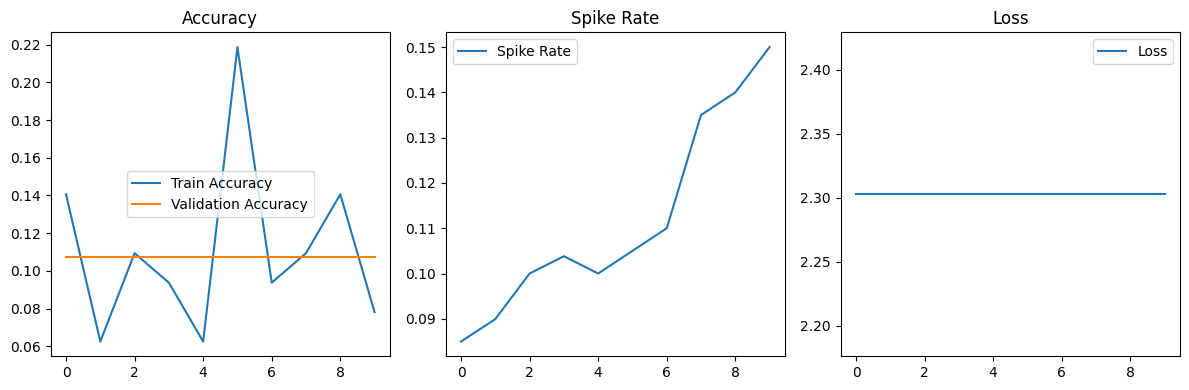

In [19]:
# snn_speech_baseline.py
# Baseline SNN for Google Speech Commands classification using snntorch

import torch
import torch.nn as nn
import torchaudio
import snntorch as snn
from torch.utils.data import DataLoader, Dataset

from snntorch import surrogate
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Hyperparameters
batch_size = 64
num_steps = 25
num_inputs = 13 * 100  # 13 MFCC coefficients x 100 frames
num_hidden = 100
num_outputs = 10  # Number of target words
learning_rate = 1e-3
num_epochs = 10
max_frames = 100  # MFCC time-steps (padded/cropped to 100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Classes to recognize
target_classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

# Define dataset
class SubsetSC(torchaudio.datasets.SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__(root="./data", download=True)
        if subset == "validation":
            self._walker = self._load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = self._load_list("testing_list.txt")
        elif subset == "training":
            excludes = set(self._load_list("validation_list.txt") + self._load_list("testing_list.txt"))
            self._walker = [w for w in self._walker if w not in excludes]

    def _load_list(self, filename):
        filepath = os.path.join(self._path, filename)
        with open(filepath) as f:
            return [os.path.join(self._path, line.strip()) for line in f]

# MFCC transform
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
)

# Speech dataset class
class SpeechCommandsMFCC(Dataset):
    def __init__(self, subset, classes, mfcc_transform, max_frames=100):
        self.dataset = SubsetSC(subset)
        self.classes = classes
        self.mfcc_transform = mfcc_transform
        self.max_frames = max_frames
        self.indices = [i for i in range(len(self.dataset)) if self.dataset[i][2] in classes]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        waveform, sample_rate, label, *_ = self.dataset[self.indices[idx]]
        mfcc = self.mfcc_transform(waveform).squeeze(0)  # shape (n_mfcc, time)

        # Normalize MFCC
        mfcc = mfcc - mfcc.min()
        if mfcc.max() != 0:
            mfcc = mfcc / mfcc.max()

        # Pad or crop
        n_mfcc, time_steps = mfcc.shape
        if time_steps < self.max_frames:
            pad_size = self.max_frames - time_steps
            mfcc = F.pad(mfcc, (0, pad_size))
        else:
            mfcc = mfcc[:, :self.max_frames]

        x = mfcc.flatten()
        y = self.classes.index(label)
        return x, y

# Load datasets
train_dataset = SpeechCommandsMFCC('training', target_classes, mfcc_transform, max_frames)
val_dataset = SpeechCommandsMFCC('validation', target_classes, mfcc_transform, max_frames)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Surrogate gradient
spike_grad = surrogate.fast_sigmoid(slope=25)

# SNN model
class BaselineSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=spike_grad)

    def forward(self, x):
        batch_size = x.size(1)
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        spk1_rec, spk2_rec = [], []
        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)
        return torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0)

# Instantiate model
net = BaselineSNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Training
accuracies, val_accuracies, spike_rates, losses = [], [], [], []
for epoch in range(num_epochs):
    net.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        batch_size_actual = inputs.size(0)

        # Normalize
        if inputs.max() > 0:
            inputs = inputs / inputs.max()

        # Generate spike train input
        spike_inputs = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < inputs.unsqueeze(0) * 0.3).float()

        spk1_rec, outputs = net(spike_inputs)
        spk_count = outputs.sum(dim=0)

        loss = criterion(spk_count, labels)
        spike_rate = (spk1_rec.mean() + outputs.mean()) / 2

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()

        correct = (spk_count.argmax(dim=1) == labels).sum().item()
        accuracy = correct / batch_size_actual

    scheduler.step()
    losses.append(loss.item())
    spike_rates.append(spike_rate.item())
    accuracies.append(accuracy)

    # Validation
    net.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            batch_size_actual = inputs.size(0)

            if inputs.max() > 0:
                inputs = inputs / inputs.max()

            spike_inputs = (torch.rand(num_steps, batch_size_actual, num_inputs, device=device) < inputs.unsqueeze(0) * 0.3).float()

            spk1_rec, outputs = net(spike_inputs)
            spk_count = outputs.sum(dim=0)

            total_correct += (spk_count.argmax(dim=1) == labels).sum().item()
            total_samples += batch_size_actual

    val_accuracy = total_correct / total_samples
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Spike Rate: {spike_rate.item():.4f}, Train Accuracy: {accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(spike_rates, label="Spike Rate")
plt.title("Spike Rate")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("speech_baseline_results.png")
plt.show()


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import random_split, DataLoader
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
data_path = './'
train_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True, subset='training')
val_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True, subset='validation')

target_classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
class_to_idx = {label: idx for idx, label in enumerate(target_classes)}

def preprocess(waveform, sample_rate):
    transform = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=20,
        melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 64}
    )
    mfcc = transform(waveform)
    mfcc = mfcc.squeeze(0)
    return mfcc

class SubsetSC(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.subset = subset
        self.samples = [(waveform, sample_rate, label) for waveform, sample_rate, label, *_ in subset if label in target_classes]

    def __getitem__(self, index):
        waveform, sample_rate, label = self.samples[index]
        mfcc = preprocess(waveform, sample_rate)
        return mfcc, class_to_idx[label]

    def __len__(self):
        return len(self.samples)

train_dataset = SubsetSC(train_dataset)
val_dataset = SubsetSC(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)

# SNN Model
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = LIFNeuron()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = LIFNeuron()

    def forward(self, x):
        batch_size, steps, features = x.shape
        spk2_rec = []
        mem1 = self.lif1.init_mem(batch_size, self.fc1.out_features, x.device)
        mem2 = self.lif2.init_mem(batch_size, self.fc2.out_features, x.device)

        for step in range(steps):
            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)

class LIFNeuron(nn.Module):
    def __init__(self, tau=2.0):
        super().__init__()
        self.tau = tau

    def forward(self, x, mem):
        mem = mem * self.tau + x
        spk = (mem >= 1.0).float()
        mem = mem * (1.0 - spk)
        return spk, mem

    def init_mem(self, batch_size, features, device):
        return torch.zeros(batch_size, features, device=device)

# Poisson Encoder
def poisson_encode(x, num_steps):
    shape = (num_steps,) + x.shape
    return (torch.rand(shape, device=x.device) < x.unsqueeze(0)).float()

# Training Config
input_size = 20 * 81
hidden_size = 256
output_size = 10
num_epochs = 10
num_steps = 20

net = SNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(num_epochs):
    net.train()
    running_loss, correct, total_spikes = 0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs / inputs.max()
        inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))

        spk_in = poisson_encode(inputs, num_steps)
        spk2_rec = net(spk_in)
        spk_count = spk2_rec.sum(0)

        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        correct += (spk_count.argmax(1) == targets).sum().item()
        total_spikes += spk2_rec.sum().item()

    scheduler.step()

    train_acc = correct / len(train_loader.dataset)
    avg_loss = running_loss / len(train_loader)
    avg_spike_rate = total_spikes / (len(train_loader.dataset) * num_steps * hidden_size)

    # Validation
    net.eval()
    correct = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs / inputs.max()
            inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))

            spk_in = poisson_encode(inputs, num_steps)
            spk2_rec = net(spk_in)
            spk_count = spk2_rec.sum(0)

            correct += (spk_count.argmax(1) == targets).sum().item()

    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Spike Rate: {avg_spike_rate:.4f}, Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Total Spikes: {total_spikes:.1f}")


RuntimeError: stack expects each tensor to be equal size, but got [20, 101] at entry 0 and [20, 99] at entry 6

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
data_path = './'
train_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True, subset='training')
val_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True, subset='validation')

target_classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
class_to_idx = {label: idx for idx, label in enumerate(target_classes)}

# Constants
FIXED_MFCC_LENGTH = 100  # 🔥 Fix MFCC to this many frames always

def preprocess(waveform, sample_rate):
    transform = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=20,
        melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 64}
    )
    mfcc = transform(waveform).squeeze(0)  # [20, Time]
    time_steps = mfcc.shape[1]

    if time_steps < FIXED_MFCC_LENGTH:
        pad_amt = FIXED_MFCC_LENGTH - time_steps
        mfcc = F.pad(mfcc, (0, pad_amt))
    else:
        mfcc = mfcc[:, :FIXED_MFCC_LENGTH]

    return mfcc

class SubsetSC(torch.utils.data.Dataset):
    def __init__(self, subset):
        self.subset = subset
        self.samples = [(waveform, sample_rate, label) for waveform, sample_rate, label, *_ in subset if label in target_classes]

    def __getitem__(self, index):
        waveform, sample_rate, label = self.samples[index]
        mfcc = preprocess(waveform, sample_rate)
        return mfcc, class_to_idx[label]

    def __len__(self):
        return len(self.samples)

train_dataset = SubsetSC(train_dataset)
val_dataset = SubsetSC(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)

# SNN Model
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = LIFNeuron()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = LIFNeuron()

    def forward(self, x):
        batch_size, steps, features = x.shape
        spk2_rec = []
        mem1 = self.lif1.init_mem(batch_size, self.fc1.out_features, x.device)
        mem2 = self.lif2.init_mem(batch_size, self.fc2.out_features, x.device)

        for step in range(steps):
            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)

class LIFNeuron(nn.Module):
    def __init__(self, tau=2.0):
        super().__init__()
        self.tau = tau

    def forward(self, x, mem):
        mem = mem * self.tau + x
        spk = (mem >= 1.0).float()
        mem = mem * (1.0 - spk)
        return spk, mem

    def init_mem(self, batch_size, features, device):
        return torch.zeros(batch_size, features, device=device)

# Poisson Encoder
def poisson_encode(x, num_steps):
    shape = (num_steps,) + x.shape
    return (torch.rand(shape, device=x.device) < x.unsqueeze(0)).float()

# Training Config
input_size = 20 * FIXED_MFCC_LENGTH
hidden_size = 256
output_size = 10
num_epochs = 10
num_steps = 20

net = SNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(num_epochs):
    net.train()
    running_loss, correct, total_spikes = 0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs / inputs.max()
        inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))

        spk_in = poisson_encode(inputs, num_steps)
        spk2_rec = net(spk_in)
        spk_count = spk2_rec.sum(0)

        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        correct += (spk_count.argmax(1) == targets).sum().item()
        total_spikes += spk2_rec.sum().item()

    scheduler.step()

    train_acc = correct / len(train_loader.dataset)
    avg_loss = running_loss / len(train_loader)
    avg_spike_rate = total_spikes / (len(train_loader.dataset) * num_steps * hidden_size)

    # Validation
    net.eval()
    correct = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs / inputs.max()
            inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))

            spk_in = poisson_encode(inputs, num_steps)
            spk2_rec = net(spk_in)
            spk_count = spk2_rec.sum(0)

            correct += (spk_count.argmax(1) == targets).sum().item()

    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Spike Rate: {avg_spike_rate:.4f}, Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Total Spikes: {total_spikes:.1f}")


ValueError: too many values to unpack (expected 3)

In [22]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader
from tqdm import tqdm  # Progress bar

# Set seeds for reproducibility
torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Path
data_path = os.path.join(os.getcwd(), "speechcommands_data")
os.makedirs(data_path, exist_ok=True)

# Target Classes
target_classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
class_to_idx = {label: idx for idx, label in enumerate(target_classes)}

# Constants
FIXED_MFCC_LENGTH = 100  # 🔥 Fix MFCC to this many frames always

# Preprocessing MFCC
def preprocess(waveform, sample_rate):
    transform = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=20,
        melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 64}
    )
    mfcc = transform(waveform).squeeze(0)  # [20, Time]
    time_steps = mfcc.shape[1]

    if time_steps < FIXED_MFCC_LENGTH:
        pad_amt = FIXED_MFCC_LENGTH - time_steps
        mfcc = F.pad(mfcc, (0, pad_amt))
    else:
        mfcc = mfcc[:, :FIXED_MFCC_LENGTH]

    return mfcc

# Subset SpeechCommands
class SubsetSC(torch.utils.data.Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __getitem__(self, index):
        waveform, sample_rate, label, *_ = self.samples[index]
        mfcc = preprocess(waveform, sample_rate)
        return mfcc, class_to_idx[label]

    def __len__(self):
        return len(self.samples)

# Load complete dataset
full_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True)

# Load official splits
def load_list(filename):
    filepath = os.path.join(data_path, filename)
    with open(filepath) as f:
        return [os.path.normpath(os.path.join(data_path, line.strip())) for line in f]

train_list = load_list("training_list.txt")
val_list = load_list("validation_list.txt")

# Filter samples
train_samples = [sample for sample in full_dataset if sample[3] in train_list and sample[2] in target_classes]
val_samples = [sample for sample in full_dataset if sample[3] in val_list and sample[2] in target_classes]

# Create dataset objects
train_dataset = SubsetSC(train_samples)
val_dataset = SubsetSC(val_samples)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)

# Leaky Integrate and Fire Neuron
class LIFNeuron(nn.Module):
    def __init__(self, tau=2.0):
        super().__init__()
        self.tau = tau

    def forward(self, x, mem):
        mem = mem * self.tau + x
        spk = (mem >= 1.0).float()
        mem = mem * (1.0 - spk)
        return spk, mem

    def init_mem(self, batch_size, features, device):
        return torch.zeros(batch_size, features, device=device)

# SNN Model
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = LIFNeuron()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = LIFNeuron()

    def forward(self, x):
        batch_size, steps, features = x.shape
        spk2_rec = []
        mem1 = self.lif1.init_mem(batch_size, self.fc1.out_features, x.device)
        mem2 = self.lif2.init_mem(batch_size, self.fc2.out_features, x.device)

        for step in range(steps):
            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)

# Poisson Encoder
def poisson_encode(x, num_steps):
    shape = (num_steps,) + x.shape
    return (torch.rand(shape, device=x.device) < x.unsqueeze(0)).float()

# Training Config
input_size = 20 * FIXED_MFCC_LENGTH
hidden_size = 256
output_size = 10
num_epochs = 10
num_steps = 20

net = SNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(num_epochs):
    net.train()
    running_loss, correct, total_spikes = 0, 0, 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)

    for inputs, targets in train_loader_tqdm:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs / inputs.max()
        inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))

        spk_in = poisson_encode(inputs, num_steps)
        spk2_rec = net(spk_in)
        spk_count = spk2_rec.sum(0)

        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        correct += (spk_count.argmax(1) == targets).sum().item()
        total_spikes += spk2_rec.sum().item()

    scheduler.step()

    train_acc = correct / len(train_loader.dataset)
    avg_loss = running_loss / len(train_loader)
    avg_spike_rate = total_spikes / (len(train_loader.dataset) * num_steps * hidden_size)

    # Validation
    net.eval()
    correct = 0
    with torch.no_grad():
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)

        for inputs, targets in val_loader_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs / inputs.max()
            inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))

            spk_in = poisson_encode(inputs, num_steps)
            spk2_rec = net(spk_in)
            spk_count = spk2_rec.sum(0)

            correct += (spk_count.argmax(1) == targets).sum().item()

    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Spike Rate: {avg_spike_rate:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Total Spikes: {total_spikes:.1f}")


100%|██████████| 2.26G/2.26G [10:43<00:00, 3.78MB/s] 


FileNotFoundError: [Errno 2] No such file or directory: "d:\\Snn's\\speechcommands_data\\training_list.txt"

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
data_path = './speechcommands_data'
target_classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
class_to_idx = {label: idx for idx, label in enumerate(target_classes)}
FIXED_MFCC_LENGTH = 100  # 🔥 Fix MFCC to this many frames always

# Preprocess Function
def preprocess(waveform, sample_rate):
    transform = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=20,
        melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 64}
    )
    mfcc = transform(waveform).squeeze(0)  # [20, Time]
    time_steps = mfcc.shape[1]

    if time_steps < FIXED_MFCC_LENGTH:
        pad_amt = FIXED_MFCC_LENGTH - time_steps
        mfcc = F.pad(mfcc, (0, pad_amt))
    else:
        mfcc = mfcc[:, :FIXED_MFCC_LENGTH]

    return mfcc

# Dataset Wrapper
class SubsetSC(torch.utils.data.Dataset):
    def __init__(self, samples):
        self.samples = [(waveform, sample_rate, label) for waveform, sample_rate, label, *_ in samples if label in target_classes]

    def __getitem__(self, index):
        waveform, sample_rate, label = self.samples[index]
        mfcc = preprocess(waveform, sample_rate)
        return mfcc, class_to_idx[label]

    def __len__(self):
        return len(self.samples)

# --- 🛠️ Dataset Loading Correctly ---
# Use torchaudio's subset support, NO manual file reads needed
full_train_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True, subset='training')
full_val_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True, subset='validation')

# Filter only target classes
train_dataset = SubsetSC(full_train_dataset)
val_dataset = SubsetSC(full_val_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)

# --- SNN Model ---
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = LIFNeuron()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = LIFNeuron()

    def forward(self, x):
        batch_size, steps, features = x.shape
        spk2_rec = []
        mem1 = self.lif1.init_mem(batch_size, self.fc1.out_features, x.device)
        mem2 = self.lif2.init_mem(batch_size, self.fc2.out_features, x.device)

        for step in range(steps):
            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)

class LIFNeuron(nn.Module):
    def __init__(self, tau=2.0):
        super().__init__()
        self.tau = tau

    def forward(self, x, mem):
        mem = mem * self.tau + x
        spk = (mem >= 1.0).float()
        mem = mem * (1.0 - spk)
        return spk, mem

    def init_mem(self, batch_size, features, device):
        return torch.zeros(batch_size, features, device=device)

# Poisson Encoder
def poisson_encode(x, num_steps):
    shape = (num_steps,) + x.shape
    return (torch.rand(shape, device=x.device) < x.unsqueeze(0)).float()

# --- Training Config ---
input_size = 20 * FIXED_MFCC_LENGTH
hidden_size = 256
output_size = 10
num_epochs = 10
num_steps = 20

net = SNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# --- Training Loop ---
for epoch in range(num_epochs):
    net.train()
    running_loss, correct, total_spikes = 0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs / inputs.max()
        inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))  # [Batch, Steps, Features]

        spk_in = poisson_encode(inputs, num_steps)
        spk2_rec = net(spk_in)
        spk_count = spk2_rec.sum(0)

        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        correct += (spk_count.argmax(1) == targets).sum().item()
        total_spikes += spk2_rec.sum().item()

    scheduler.step()

    train_acc = correct / len(train_loader.dataset)
    avg_loss = running_loss / len(train_loader)
    avg_spike_rate = total_spikes / (len(train_loader.dataset) * num_steps * hidden_size)

    # --- Validation ---
    net.eval()
    correct = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs / inputs.max()
            inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))

            spk_in = poisson_encode(inputs, num_steps)
            spk2_rec = net(spk_in)
            spk_count = spk2_rec.sum(0)

            correct += (spk_count.argmax(1) == targets).sum().item()

    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Spike Rate: {avg_spike_rate:.4f}, Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Total Spikes: {total_spikes:.1f}")


ValueError: too many values to unpack (expected 3)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader
import random
import os

# Set seeds for reproducibility
torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
data_path = './'
dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True)

target_classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
class_to_idx = {label: idx for idx, label in enumerate(target_classes)}

# Parse dataset
def load_list(filename):
    filepath = os.path.join(data_path, "SpeechCommands", filename)
    with open(filepath) as f:
        return [os.path.normpath(os.path.join(data_path, "SpeechCommands", line.strip())) for line in f]

train_list = load_list("training_list.txt")
val_list = load_list("validation_list.txt")

def subset_dataset(dataset, file_list):
    files_set = set(file_list)
    return [(waveform, sample_rate, label) for waveform, sample_rate, label, *_ in dataset 
            if label in target_classes and dataset._walker[dataset.samples.index((waveform, sample_rate, label, None))] in files_set]

train_samples = subset_dataset(dataset, train_list)
val_samples = subset_dataset(dataset, val_list)

# Constants
FIXED_MFCC_LENGTH = 100

def preprocess(waveform, sample_rate):
    transform = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=20,
        melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 64}
    )
    mfcc = transform(waveform).squeeze(0).float()  # [20, Time]
    time_steps = mfcc.shape[1]

    if time_steps < FIXED_MFCC_LENGTH:
        pad_amt = FIXED_MFCC_LENGTH - time_steps
        mfcc = F.pad(mfcc, (0, pad_amt))
    else:
        mfcc = mfcc[:, :FIXED_MFCC_LENGTH]

    return mfcc

class SubsetSC(torch.utils.data.Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __getitem__(self, index):
        waveform, sample_rate, label = self.samples[index]
        mfcc = preprocess(waveform, sample_rate)
        return mfcc, class_to_idx[label]

    def __len__(self):
        return len(self.samples)

train_dataset = SubsetSC(train_samples)
val_dataset = SubsetSC(val_samples)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# SNN
class LIFNeuron(nn.Module):
    def __init__(self, tau=2.0):
        super().__init__()
        self.tau = tau

    def forward(self, x, mem):
        mem = mem * self.tau + x
        spk = (mem >= 1.0).float()
        mem = mem * (1.0 - spk)
        return spk, mem

    def init_mem(self, batch_size, features, device):
        return torch.zeros(batch_size, features, device=device)

class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = LIFNeuron()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = LIFNeuron()

    def forward(self, x):
        batch_size, steps, features = x.shape
        spk2_rec = []
        mem1 = self.lif1.init_mem(batch_size, self.fc1.out_features, x.device)
        mem2 = self.lif2.init_mem(batch_size, self.fc2.out_features, x.device)

        for step in range(steps):
            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)

# Poisson Encoding optimized
def poisson_encode(x, num_steps):
    shape = (num_steps,) + x.shape
    return (torch.rand(shape, device=x.device) < x.unsqueeze(0)).float()

# Train Config
input_size = 20 * FIXED_MFCC_LENGTH
hidden_size = 256
output_size = 10
num_epochs = 10
num_steps = 20

net = SNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Training
for epoch in range(num_epochs):
    net.train()
    running_loss, correct, total_spikes = 0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.float().to(device), targets.to(device)
        inputs = inputs / (inputs.max(dim=2, keepdim=True)[0] + 1e-5)  # Normalization per sample
        inputs = inputs.permute(0, 2, 1)  # [batch, steps, features]

        spk_in = poisson_encode(inputs, num_steps)

        spk2_rec = net(spk_in)
        spk_count = spk2_rec.sum(0)

        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        correct += (spk_count.argmax(1) == targets).sum().item()
        total_spikes += spk2_rec.sum().item()

    scheduler.step()

    train_acc = correct / len(train_loader.dataset)
    avg_loss = running_loss / len(train_loader)
    avg_spike_rate = total_spikes / (len(train_loader.dataset) * num_steps * hidden_size)

    # Validation
    net.eval()
    correct = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.float().to(device), targets.to(device)
            inputs = inputs / (inputs.max(dim=2, keepdim=True)[0] + 1e-5)
            inputs = inputs.permute(0, 2, 1)

            spk_in = poisson_encode(inputs, num_steps)
            spk2_rec = net(spk_in)
            spk_count = spk2_rec.sum(0)

            correct += (spk_count.argmax(1) == targets).sum().item()

    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Spike Rate: {avg_spike_rate:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Total Spikes: {total_spikes:.1f}")


FileNotFoundError: [Errno 2] No such file or directory: './SpeechCommands\\training_list.txt'

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
data_path = './speechcommands_data'
target_classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
class_to_idx = {label: idx for idx, label in enumerate(target_classes)}
FIXED_MFCC_LENGTH = 100  # 🔥 Fix MFCC to this many frames always

# Preprocess Function
def preprocess(waveform, sample_rate):
    transform = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=20,
        melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 64}
    )
    mfcc = transform(waveform).squeeze(0)  # [20, Time]
    time_steps = mfcc.shape[1]

    if time_steps < FIXED_MFCC_LENGTH:
        pad_amt = FIXED_MFCC_LENGTH - time_steps
        mfcc = F.pad(mfcc, (0, pad_amt))
    else:
        mfcc = mfcc[:, :FIXED_MFCC_LENGTH]

    return mfcc

# Dataset Wrapper
class SubsetSC(torch.utils.data.Dataset):
    def __init__(self, samples):
        self.samples = [(waveform, sample_rate, label) for waveform, sample_rate, label, *_ in samples if label in target_classes]

    def __getitem__(self, index):
        waveform, sample_rate, label = self.samples[index]
        mfcc = preprocess(waveform, sample_rate)
        return mfcc, class_to_idx[label]

    def __len__(self):
        return len(self.samples)

# --- 🛠️ Dataset Loading Correctly ---
full_train_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True, subset='training')
full_val_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True, subset='validation')

# Filter only target classes
train_dataset = SubsetSC(full_train_dataset)
val_dataset = SubsetSC(full_val_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)

# --- SNN Model ---
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = LIFNeuron()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = LIFNeuron()

    def forward(self, x):
        batch_size, steps, features = x.shape
        spk2_rec = []
        mem1 = self.lif1.init_mem(batch_size, self.fc1.out_features, x.device)
        mem2 = self.lif2.init_mem(batch_size, self.fc2.out_features, x.device)

        for step in range(steps):
            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)

class LIFNeuron(nn.Module):
    def __init__(self, tau=2.0):
        super().__init__()
        self.tau = tau

    def forward(self, x, mem):
        mem = mem * self.tau + x
        spk = (mem >= 1.0).float()
        mem = mem * (1.0 - spk)
        return spk, mem

    def init_mem(self, batch_size, features, device):
        return torch.zeros(batch_size, features, device=device)

# Poisson Encoder
def poisson_encode(x, num_steps):
    shape = (num_steps,) + x.shape
    return (torch.rand(shape, device=x.device) < x.unsqueeze(0)).float()

# --- Training Config ---
input_size = 20 * FIXED_MFCC_LENGTH
hidden_size = 256
output_size = 10
num_epochs = 10
num_steps = 20

net = SNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# --- Training Loop ---
for epoch in range(num_epochs):
    net.train()
    running_loss, correct, total_spikes = 0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs / inputs.max()
        inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))  # [Batch, Steps, Features]

        spk_in = poisson_encode(inputs, num_steps)
        spk_in = spk_in.permute(1, 0, 2, 3)           # (batch_size, num_steps, steps, features)
        spk_in = spk_in.reshape(spk_in.size(0), spk_in.size(1), -1)  # (batch_size, num_steps, steps*features)

        spk2_rec = net(spk_in)
        spk_count = spk2_rec.sum(0)

        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        correct += (spk_count.argmax(1) == targets).sum().item()
        total_spikes += spk2_rec.sum().item()

    scheduler.step()

    train_acc = correct / len(train_loader.dataset)
    avg_loss = running_loss / len(train_loader)
    avg_spike_rate = total_spikes / (len(train_loader.dataset) * num_steps * hidden_size)

    # --- Validation ---
    net.eval()
    correct = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs / inputs.max()
            inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))

            spk_in = poisson_encode(inputs, num_steps)
            spk_in = spk_in.permute(1, 0, 2, 3)
            spk_in = spk_in.reshape(spk_in.size(0), spk_in.size(1), -1)

            spk2_rec = net(spk_in)
            spk_count = spk2_rec.sum(0)

            correct += (spk_count.argmax(1) == targets).sum().item()

    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Spike Rate: {avg_spike_rate:.4f}, Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Total Spikes: {total_spikes:.1f}")


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
data_path = './speechcommands_data'
target_classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
class_to_idx = {label: idx for idx, label in enumerate(target_classes)}
FIXED_MFCC_LENGTH = 100  # 🔥 Fix MFCC to this many frames always

# Preprocess Function
def preprocess(waveform, sample_rate):
    transform = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=20,
        melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 64}
    )
    mfcc = transform(waveform).squeeze(0)  # [20, Time]
    time_steps = mfcc.shape[1]

    if time_steps < FIXED_MFCC_LENGTH:
        pad_amt = FIXED_MFCC_LENGTH - time_steps
        mfcc = F.pad(mfcc, (0, pad_amt))
    else:
        mfcc = mfcc[:, :FIXED_MFCC_LENGTH]

    return mfcc

# Dataset Wrapper
class SubsetSC(torch.utils.data.Dataset):
    def __init__(self, samples):
        self.samples = [(waveform, sample_rate, label) for waveform, sample_rate, label, *_ in samples if label in target_classes]

    def __getitem__(self, index):
        waveform, sample_rate, label = self.samples[index]
        mfcc = preprocess(waveform, sample_rate)
        return mfcc, class_to_idx[label]

    def __len__(self):
        return len(self.samples)

# --- Dataset Loading ---
full_train_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True, subset='training')
full_val_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True, subset='validation')

train_dataset = SubsetSC(full_train_dataset)
val_dataset = SubsetSC(full_val_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)

# --- SNN Model ---
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = LIFNeuron()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = LIFNeuron()

    def forward(self, x):
        batch_size, steps, features = x.shape
        spk2_rec = []
        mem1 = self.lif1.init_mem(batch_size, self.fc1.out_features, x.device)
        mem2 = self.lif2.init_mem(batch_size, self.fc2.out_features, x.device)

        for step in range(steps):
            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)

class LIFNeuron(nn.Module):
    def __init__(self, tau=2.0):
        super().__init__()
        self.tau = tau

    def forward(self, x, mem):
        mem = mem * self.tau + x
        spk = (mem >= 1.0).float()
        mem = mem * (1.0 - spk)
        return spk, mem

    def init_mem(self, batch_size, features, device):
        return torch.zeros(batch_size, features, device=device)

# Poisson Encoder
def poisson_encode(x, num_steps):
    shape = (num_steps,) + x.shape
    return (torch.rand(shape, device=x.device) < x.unsqueeze(0)).float()

# --- Training Config ---
input_size = 20 * FIXED_MFCC_LENGTH
hidden_size = 256
output_size = 10
num_epochs = 10
num_steps = 20

net = SNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# --- Training Loop ---
for epoch in range(num_epochs):
    net.train()
    running_loss, correct, total_spikes = 0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs / inputs.max()
        inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))  # [Batch, Steps, Features]

        spk_in = poisson_encode(inputs, num_steps)
        spk_in = spk_in.permute(1, 0, 2, 3)           # (num_steps, batch, steps, features)
        spk_in = spk_in.reshape(spk_in.size(0), spk_in.size(1), -1)  # (num_steps, batch, steps*features)

        spk2_rec = net(spk_in)                          # (time, batch, classes)
        spk_count = spk2_rec.sum(0) / num_steps         # ✅ FIXED: average over steps

        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        correct += (spk_count.argmax(1) == targets).sum().item()
        total_spikes += spk2_rec.sum().item()

    scheduler.step()

    train_acc = correct / len(train_loader.dataset)
    avg_loss = running_loss / len(train_loader)
    avg_spike_rate = total_spikes / (len(train_loader.dataset) * num_steps * hidden_size)

    # --- Validation ---
    net.eval()
    correct = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs / inputs.max()
            inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))

            spk_in = poisson_encode(inputs, num_steps)
            spk_in = spk_in.permute(1, 0, 2, 3)
            spk_in = spk_in.reshape(spk_in.size(0), spk_in.size(1), -1)

            spk2_rec = net(spk_in)
            spk_count = spk2_rec.sum(0) / num_steps    # ✅ SAME FIX IN VALIDATION

            correct += (spk_count.argmax(1) == targets).sum().item()

    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Spike Rate: {avg_spike_rate:.4f}, Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Total Spikes: {total_spikes:.1f}")


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
data_path = './speechcommands_data'
target_classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
class_to_idx = {label: idx for idx, label in enumerate(target_classes)}
FIXED_MFCC_LENGTH = 100  # 🔥 Fix MFCC to this many frames always

# Preprocess Function
def preprocess(waveform, sample_rate):
    transform = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=20,
        melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 64}
    )
    mfcc = transform(waveform).squeeze(0)  # [20, Time]
    time_steps = mfcc.shape[1]

    if time_steps < FIXED_MFCC_LENGTH:
        pad_amt = FIXED_MFCC_LENGTH - time_steps
        mfcc = F.pad(mfcc, (0, pad_amt))
    else:
        mfcc = mfcc[:, :FIXED_MFCC_LENGTH]

    return mfcc

# Dataset Wrapper
class SubsetSC(torch.utils.data.Dataset):
    def __init__(self, samples):
        self.samples = [(waveform, sample_rate, label) for waveform, sample_rate, label, *_ in samples if label in target_classes]

    def __getitem__(self, index):
        waveform, sample_rate, label = self.samples[index]
        mfcc = preprocess(waveform, sample_rate)
        return mfcc, class_to_idx[label]

    def __len__(self):
        return len(self.samples)

# --- Dataset Loading ---
full_train_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True, subset='training')
full_val_dataset = torchaudio.datasets.SPEECHCOMMANDS(root=data_path, download=True, subset='validation')

train_dataset = SubsetSC(full_train_dataset)
val_dataset = SubsetSC(full_val_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)

# --- SNN Model ---
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = LIFNeuron()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = LIFNeuron()

    def forward(self, x):
        batch_size, steps, features = x.shape
        spk2_rec = []
        mem1 = self.lif1.init_mem(batch_size, self.fc1.out_features, x.device)
        mem2 = self.lif2.init_mem(batch_size, self.fc2.out_features, x.device)

        for step in range(steps):
            cur1 = self.fc1(x[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)

# 🔥 Corrected LIF Neuron with FastSigmoid surrogate
class LIFNeuron(nn.Module):
    def __init__(self, tau=2.0):
        super().__init__()
        self.tau = tau

    def forward(self, x, mem):
        mem = mem * self.tau + x
        spk = self.surrogate_spike(mem - 1.0)
        mem = mem * (1.0 - spk)
        return spk, mem

    def surrogate_spike(self, x):
        return torch.clamp(0.5 * x + 0.5, min=0.0, max=1.0)  # 🔥 FastSigmoid

    def init_mem(self, batch_size, features, device):
        return torch.zeros(batch_size, features, device=device)

# Poisson Encoder
def poisson_encode(x, num_steps):
    shape = (num_steps,) + x.shape
    return (torch.rand(shape, device=x.device) < x.unsqueeze(0)).float()

# --- Training Config ---
input_size = 20 * FIXED_MFCC_LENGTH
hidden_size = 256
output_size = 10
num_epochs = 10
num_steps = 20

net = SNN(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# --- Training Loop ---
for epoch in range(num_epochs):
    net.train()
    running_loss, correct, total_spikes = 0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs / inputs.max()
        inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))  # [Batch, Steps, Features]

        spk_in = poisson_encode(inputs, num_steps)
        spk_in = spk_in.permute(1, 0, 2, 3)           # (num_steps, batch, steps, features)
        spk_in = spk_in.reshape(spk_in.size(0), spk_in.size(1), -1)  # (num_steps, batch, steps*features)

        spk2_rec = net(spk_in)                          # (time, batch, classes)
        spk_count = spk2_rec.sum(0) / num_steps         # ✅ FIXED: average over steps

        loss = criterion(spk_count, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        correct += (spk_count.argmax(1) == targets).sum().item()
        total_spikes += spk2_rec.sum().item()

    scheduler.step()

    train_acc = correct / len(train_loader.dataset)
    avg_loss = running_loss / len(train_loader)
    avg_spike_rate = total_spikes / (len(train_loader.dataset) * num_steps * hidden_size)

    # --- Validation ---
    net.eval()
    correct = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs / inputs.max()
            inputs = inputs.view(inputs.size(0), inputs.size(2), inputs.size(1))

            spk_in = poisson_encode(inputs, num_steps)
            spk_in = spk_in.permute(1, 0, 2, 3)
            spk_in = spk_in.reshape(spk_in.size(0), spk_in.size(1), -1)

            spk2_rec = net(spk_in)
            spk_count = spk2_rec.sum(0) / num_steps

            correct += (spk_count.argmax(1) == targets).sum().item()

    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Spike Rate: {avg_spike_rate:.4f}, Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, Total Spikes: {total_spikes:.1f}")


Epoch 1, Loss: 2.2552, Spike Rate: 0.0006, Accuracy: 0.1058, Validation Accuracy: 0.1075, Total Spikes: 93941.3
Epoch 2, Loss: 2.2474, Spike Rate: 0.0006, Accuracy: 0.1048, Validation Accuracy: 0.1075, Total Spikes: 92644.0
Epoch 3, Loss: 2.2445, Spike Rate: 0.0006, Accuracy: 0.1052, Validation Accuracy: 0.1072, Total Spikes: 92492.2
Epoch 4, Loss: 2.2424, Spike Rate: 0.0006, Accuracy: 0.1048, Validation Accuracy: 0.1072, Total Spikes: 96769.1
Epoch 5, Loss: 2.2405, Spike Rate: 0.0006, Accuracy: 0.1048, Validation Accuracy: 0.1072, Total Spikes: 97059.4
Epoch 6, Loss: 2.2391, Spike Rate: 0.0006, Accuracy: 0.1048, Validation Accuracy: 0.1075, Total Spikes: 88478.4
Epoch 7, Loss: 2.2381, Spike Rate: 0.0006, Accuracy: 0.1049, Validation Accuracy: 0.1072, Total Spikes: 87547.2
Epoch 8, Loss: 2.2371, Spike Rate: 0.0006, Accuracy: 0.1048, Validation Accuracy: 0.1072, Total Spikes: 87376.1
Epoch 9, Loss: 2.2367, Spike Rate: 0.0005, Accuracy: 0.1049, Validation Accuracy: 0.1072, Total Spikes: 